In [108]:
import pandas as pd
import numpy as np
from pathlib import Path
import os



In [109]:
Path.cwd()

PosixPath('/tf/animal_clasificacion')

In [110]:

project_folder = "animal_clasificacion" 
if os.getcwd().endswith("/tf"):
    os.chdir(project_folder)

In [5]:
BASE_DIR = Path().cwd()

IMG_DIRECTORY = BASE_DIR / 'raw-img'


In [6]:

animales_show = {}

for animal in os.listdir(IMG_DIRECTORY):
    # toma solo la primera imagen encontrada en cada carpeta
    imagenes = list((IMG_DIRECTORY / animal).iterdir())
    if imagenes:
        animales_show[animal] = imagenes[0]

In [7]:
print(animales_show['gatto'])         
print(type(animales_show['gatto']))


/tf/animal_clasificacion/raw-img/gatto/1029.jpeg
<class 'pathlib.PosixPath'>


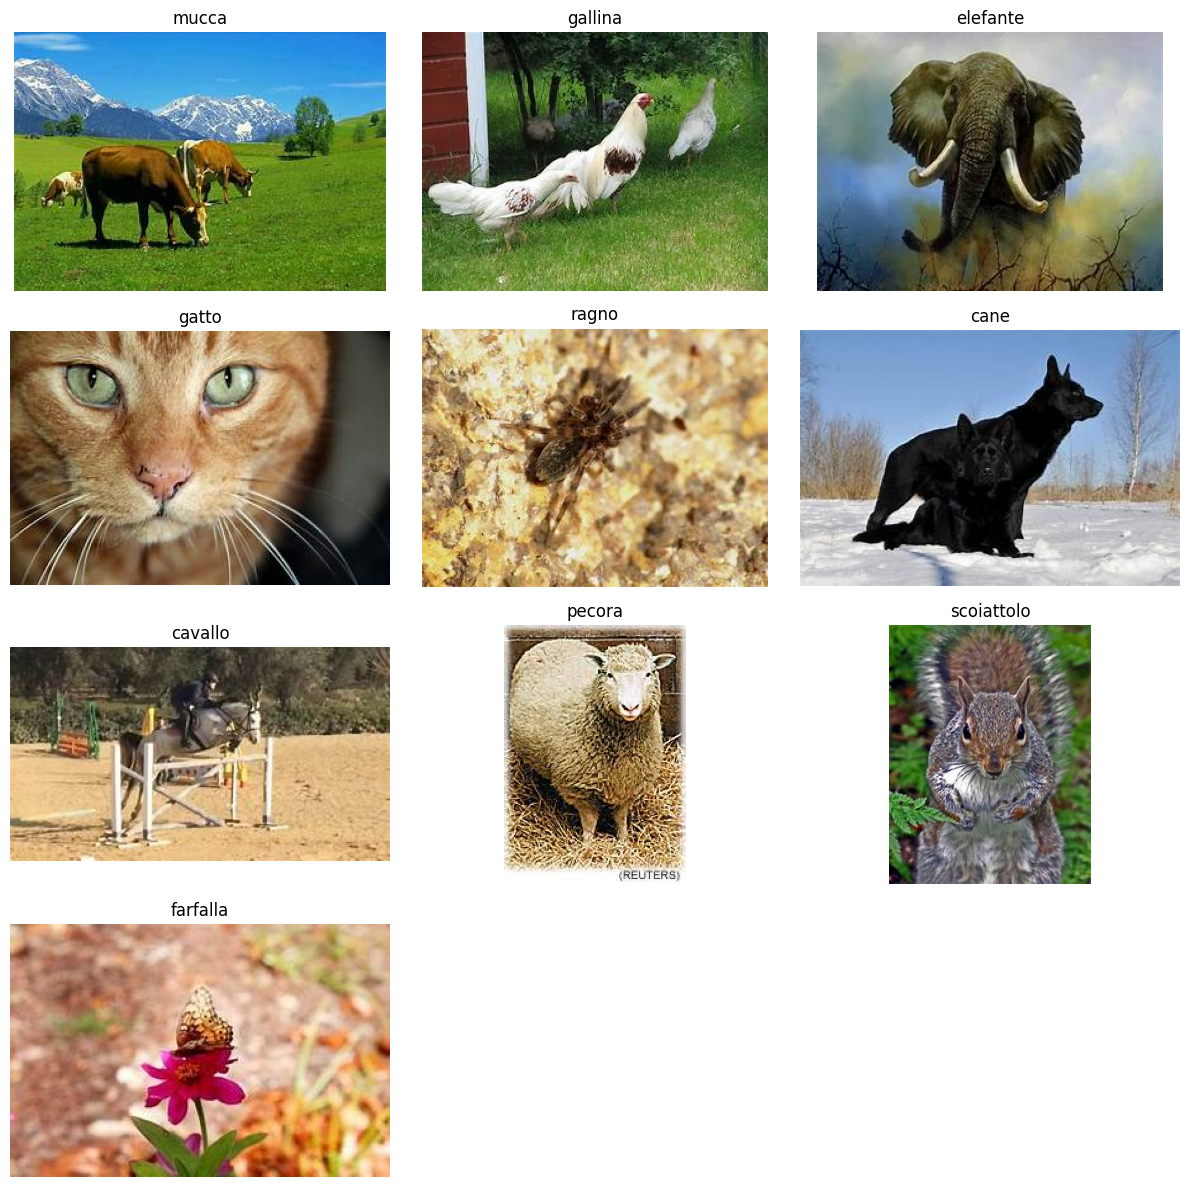

In [8]:
n_animales = len(animales_show)


fig, axes = plt.subplots(4, 3, figsize=(12, 12))  


axes = axes.flatten()

for i, (nombre, ruta) in enumerate(animales_show.items()):
    if i >= 10:
        break  # solo mostramos hasta 10imágenes 1 por cada clase.
    img = Image.open(ruta)
    
    axes[i].imshow(img)
    axes[i].set_title(nombre, fontsize=12)
    axes[i].axis('off')
    
    
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# **PROCESAMIENTO**

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


data_dir = 'raw-img'

dataset = image_dataset_from_directory(
    data_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=True
)

2025-06-17 14:56:49.074213: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-17 14:56:49.074286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-17 14:56:49.139133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 14:56:49.292626: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 26179 files belonging to 10 classes.


2025-06-17 14:56:52.004607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-17 14:56:52.171071: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-17 14:56:52.171316: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [10]:
for img, labels in dataset.take(1):
    print("Shape del batch de imágenes:", img.shape)  # (32, 224, 224, 3)
    print("Shape de las etiquetas:", labels.shape)  

Shape del batch de imágenes: (32, 224, 224, 3)
Shape de las etiquetas: (32,)


['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


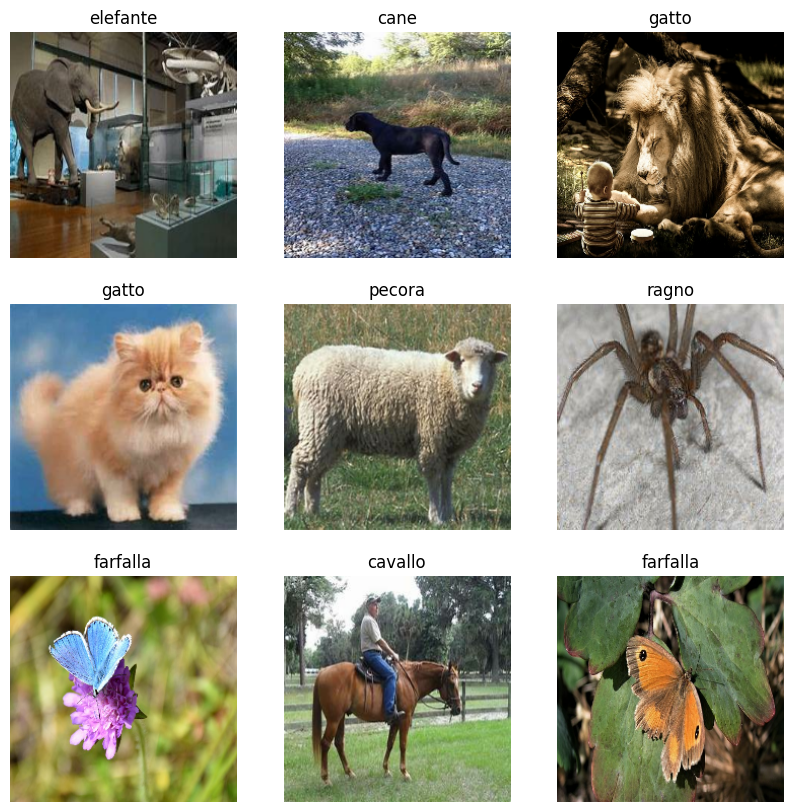

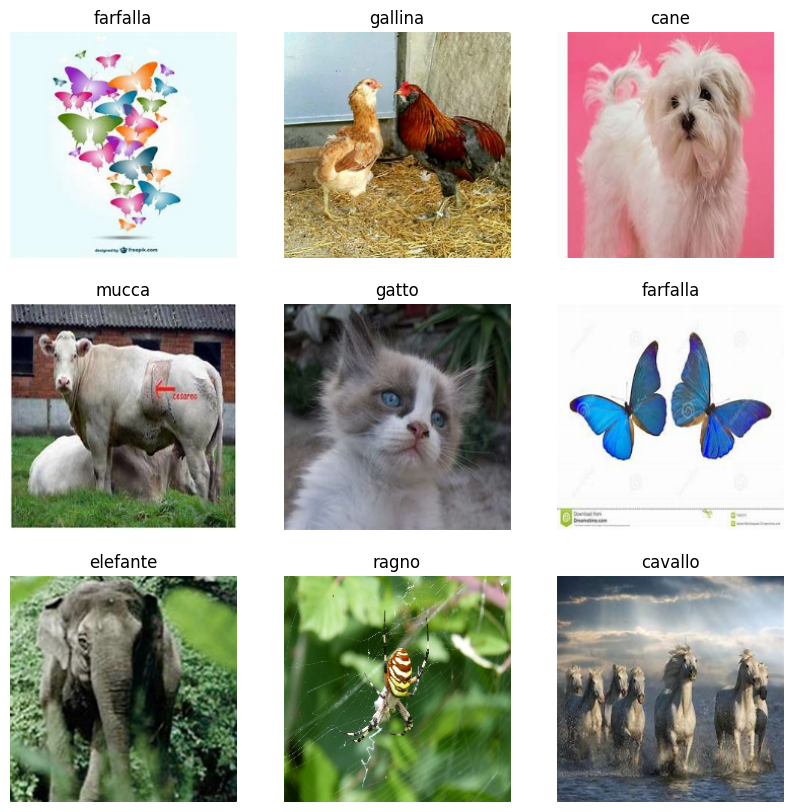

In [11]:


class_names = dataset.class_names

print(class_names)

for img, labels in dataset.take(2):
    
    plt.figure(figsize=(10, 10))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i].numpy()])      # mostrar el nombre de la clase
        plt.axis("off")

In [12]:
from tensorflow.keras.layers import Rescaling


capa_normalizadora = Rescaling(1./255)

# Toma img, label aplicando solo a la imágen la normalizacion y obteniendo la imágen normalizada
normalized_ds = dataset.map(lambda x, y: (capa_normalizadora(x), y))


In [13]:
for imagen, _ in normalized_ds.take(1):
    print("Mínimo:", imagen.numpy().min())
    print("Máximo:", imagen.numpy().max())

Mínimo: 0.0
Máximo: 1.0


# Data Augmentation

In [14]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Para mejorar el poder predictivo y generalización de los datos y evitar el overfitting se generara una data augmentation con flip horizontal, rotando y además con zoom. La idea es que esto ayde al modelo a aprender de los datos más que a memorizarlos


## **Vista general de la data augmentation**

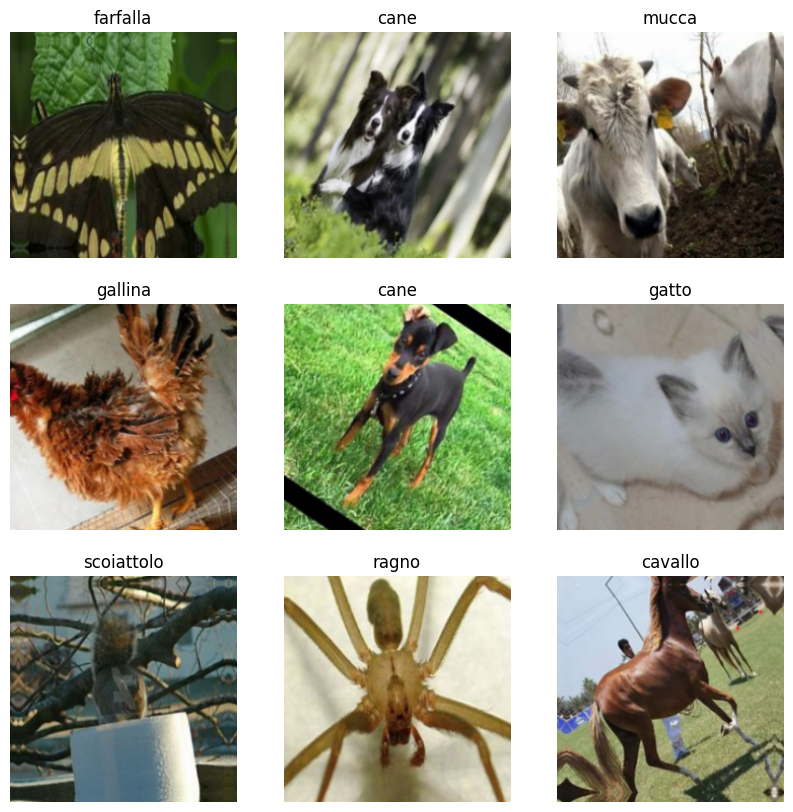

In [15]:
import matplotlib.pyplot as plt


# Vamos a tomar la primera imágen de cada clase
for images, _ in dataset.take(1):
    
    # Aplicamos la augmentation
    augmented_images = data_augmentation(images)
    
    
    
    # Graficamos
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(class_names[_[i].numpy()])
        plt.axis("off")
    break


## **DIVISION - AUGMENTATION - NORMALIZACION**

In [58]:
import numpy as np, random, tensorflow as tf
from pathlib import Path

data_dir = Path('raw-img')
img_size = (224, 224)
batch_size = 32
seed = 123

In [ ]:
class_names  = sorted([ d.name for d in data_dir.iterdir() if d.is_dir()])

class_names

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

In [63]:
archivos_por_clase = {c: sorted((data_dir/c).glob("*")) for c in class_names}


In [64]:
N_min = min(len(v) for v in archivos_por_clase.values())
N_min

1446

In [67]:
random.seed(seed)
paths, labels = [], []
for label, cname in enumerate(class_names):
    select = random.sample(archivos_por_clase[cname], N_min)
    paths.extend(map(str, select))         
    labels.extend([label] * N_min)

In [68]:

# barajar y split 80/20
zipped = list(zip(paths, labels))
random.shuffle(zipped)
paths, labels = zip(*zipped)

val_count  = int(len(paths) * 0.2)
train_paths = np.array(paths[val_count:])
train_lbls  = np.array(labels[val_count:], dtype=np.int32)
val_paths   = np.array(paths[:val_count])
val_lbls    = np.array(labels[:val_count], dtype=np.int32)

# ---------- tf.data -----------------------------------------------------
def load_image(p, y):
    img = tf.io.read_file(p)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img, y

augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1,0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def aug_map(x,y): return augment(x, training=True), y

train_ds = (tf.data.Dataset
            .from_tensor_slices((train_paths, train_lbls))
            .shuffle(len(train_paths), seed=seed)
            .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
            .map(aug_map,   num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset
          .from_tensor_slices((val_paths, val_lbls))
          .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))




In [77]:
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential


# ---------- MODELO ------------------------------------------------------
num_classes = len(class_names)


model = Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, (5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(num_classes, activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

Epoch 1/50


2025-06-17 19:19:14.819132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/362 [..............................] - ETA: 23s - loss: 4.6514 - accuracy: 0.1619

2025-06-17 19:19:19.208465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/362 [=>............................] - ETA: 23s - loss: 3.8559 - accuracy: 0.1794

2025-06-17 19:19:20.653621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/362 [======>.......................] - ETA: 18s - loss: 2.8714 - accuracy: 0.2116

2025-06-17 19:19:24.851573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/362 [===========>..................] - ETA: 15s - loss: 2.6126 - accuracy: 0.2265

2025-06-17 19:19:28.515576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:19:28.650329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/362 [===========>..................] - ETA: 14s - loss: 2.5968 - accuracy: 0.2282

2025-06-17 19:19:28.792074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/362 [==============>...............] - ETA: 11s - loss: 2.4900 - accuracy: 0.2324

2025-06-17 19:19:31.859064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


287/362 [======================>.......] - ETA: 5s - loss: 2.3478 - accuracy: 0.2448

2025-06-17 19:19:38.402252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:19:38.448340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


333/362 [==========================>...] - ETA: 2s - loss: 2.3030 - accuracy: 0.2511

2025-06-17 19:19:41.536250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


348/362 [===========================>..] - ETA: 0s - loss: 2.2906 - accuracy: 0.2531

2025-06-17 19:19:42.610856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - ETA: 0s - loss: 2.2786 - accuracy: 0.2550

2025-06-17 19:19:45.566423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:19:46.396495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 34s 81ms/step - loss: 2.2786 - accuracy: 0.2550 - val_loss: 2.7394 - val_accuracy: 0.1770 - lr: 1.0000e-04
Epoch 2/50
 13/362 [>.............................] - ETA: 24s - loss: 1.9727 - accuracy: 0.3101

2025-06-17 19:19:48.624093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/362 [=>............................] - ETA: 23s - loss: 1.9304 - accuracy: 0.3357

2025-06-17 19:19:49.938069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/362 [====>.........................] - ETA: 21s - loss: 1.9074 - accuracy: 0.3433

2025-06-17 19:19:52.371195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/362 [=====>........................] - ETA: 20s - loss: 1.9196 - accuracy: 0.3378

2025-06-17 19:19:53.030924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/362 [=====>........................] - ETA: 20s - loss: 1.9248 - accuracy: 0.3349

2025-06-17 19:19:53.565521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/362 [==========>...................] - ETA: 15s - loss: 1.9286 - accuracy: 0.3301

2025-06-17 19:19:58.076820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/362 [=============>................] - ETA: 13s - loss: 1.9293 - accuracy: 0.3323

2025-06-17 19:20:00.180665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/362 [==============>...............] - ETA: 13s - loss: 1.9279 - accuracy: 0.3336

2025-06-17 19:20:00.702644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:20:00.770625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/362 [================>.............] - ETA: 10s - loss: 1.9237 - accuracy: 0.3320

2025-06-17 19:20:03.081034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/362 [===================>..........] - ETA: 7s - loss: 1.9197 - accuracy: 0.3320

2025-06-17 19:20:05.644135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


308/362 [========================>.....] - ETA: 3s - loss: 1.9118 - accuracy: 0.3340

2025-06-17 19:20:09.604761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.9031 - accuracy: 0.3370

2025-06-17 19:20:13.610447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:20:14.425570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 76ms/step - loss: 1.9039 - accuracy: 0.3367 - val_loss: 1.7812 - val_accuracy: 0.3855 - lr: 1.0000e-04
Epoch 3/50
  4/362 [..............................] - ETA: 26s - loss: 1.7812 - accuracy: 0.4609

2025-06-17 19:20:15.596831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/362 [=>............................] - ETA: 23s - loss: 1.8345 - accuracy: 0.3711

2025-06-17 19:20:17.570578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/362 [===>..........................] - ETA: 21s - loss: 1.8258 - accuracy: 0.3791

2025-06-17 19:20:19.127915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/362 [===>..........................] - ETA: 21s - loss: 1.8344 - accuracy: 0.3766

2025-06-17 19:20:19.335154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:20:19.380540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/362 [=========>....................] - ETA: 16s - loss: 1.8287 - accuracy: 0.3728

2025-06-17 19:20:24.302245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/362 [==========>...................] - ETA: 15s - loss: 1.8290 - accuracy: 0.3715

2025-06-17 19:20:25.258495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/362 [===========>..................] - ETA: 15s - loss: 1.8314 - accuracy: 0.3701

2025-06-17 19:20:25.754879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/362 [=============>................] - ETA: 13s - loss: 1.8281 - accuracy: 0.3696

2025-06-17 19:20:27.534366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/362 [===================>..........] - ETA: 8s - loss: 1.8126 - accuracy: 0.3723

2025-06-17 19:20:32.528040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


305/362 [========================>.....] - ETA: 4s - loss: 1.7995 - accuracy: 0.3743

2025-06-17 19:20:36.878763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


336/362 [==========================>...] - ETA: 1s - loss: 1.7947 - accuracy: 0.3759

2025-06-17 19:20:39.025295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.7923 - accuracy: 0.3766

2025-06-17 19:20:41.025110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:20:41.829311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 1.7925 - accuracy: 0.3766 - val_loss: 1.8633 - val_accuracy: 0.3945 - lr: 1.0000e-04
Epoch 4/50
  2/362 [..............................] - ETA: 26s - loss: 1.5337 - accuracy: 0.4375

2025-06-17 19:20:42.792091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/362 [..............................] - ETA: 25s - loss: 1.6867 - accuracy: 0.4375

2025-06-17 19:20:43.483263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/362 [===>..........................] - ETA: 22s - loss: 1.6863 - accuracy: 0.4057

2025-06-17 19:20:46.469900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/362 [======>.......................] - ETA: 19s - loss: 1.6850 - accuracy: 0.4159

2025-06-17 19:20:49.074353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/362 [=======>......................] - ETA: 18s - loss: 1.6955 - accuracy: 0.4132

2025-06-17 19:20:50.321388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/362 [==========>...................] - ETA: 16s - loss: 1.7040 - accuracy: 0.4104

2025-06-17 19:20:52.154811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/362 [============>.................] - ETA: 14s - loss: 1.7052 - accuracy: 0.4074

2025-06-17 19:20:54.012392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/362 [==============>...............] - ETA: 12s - loss: 1.7189 - accuracy: 0.4056

2025-06-17 19:20:55.712453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/362 [=================>............] - ETA: 9s - loss: 1.7187 - accuracy: 0.4049

2025-06-17 19:20:58.725158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


334/362 [==========================>...] - ETA: 1s - loss: 1.7028 - accuracy: 0.4108

2025-06-17 19:21:06.218039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


342/362 [===========================>..] - ETA: 1s - loss: 1.7009 - accuracy: 0.4124

2025-06-17 19:21:06.769640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


356/362 [============================>.] - ETA: 0s - loss: 1.6982 - accuracy: 0.4125

2025-06-17 19:21:07.779025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.6965 - accuracy: 0.4137

2025-06-17 19:21:08.349751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:21:09.198609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 1.6965 - accuracy: 0.4136 - val_loss: 2.8766 - val_accuracy: 0.2756 - lr: 1.0000e-04
Epoch 5/50
 42/362 [==>...........................] - ETA: 23s - loss: 1.5708 - accuracy: 0.4487

2025-06-17 19:21:13.092342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/362 [======>.......................] - ETA: 20s - loss: 1.6412 - accuracy: 0.4271

2025-06-17 19:21:16.299014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/362 [=========>....................] - ETA: 17s - loss: 1.6396 - accuracy: 0.4327

2025-06-17 19:21:18.947361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/362 [===========>..................] - ETA: 15s - loss: 1.6296 - accuracy: 0.4357

2025-06-17 19:21:20.950124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/362 [==============>...............] - ETA: 12s - loss: 1.6183 - accuracy: 0.4391

2025-06-17 19:21:22.904660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/362 [==============>...............] - ETA: 12s - loss: 1.6177 - accuracy: 0.4392

2025-06-17 19:21:23.115134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/362 [==============>...............] - ETA: 12s - loss: 1.6136 - accuracy: 0.4403

2025-06-17 19:21:23.705938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/362 [==================>...........] - ETA: 8s - loss: 1.6182 - accuracy: 0.4384

2025-06-17 19:21:27.092567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/362 [====================>.........] - ETA: 7s - loss: 1.6176 - accuracy: 0.4380

2025-06-17 19:21:28.264857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


299/362 [=======================>......] - ETA: 4s - loss: 1.6178 - accuracy: 0.4384

2025-06-17 19:21:31.137545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


327/362 [==========================>...] - ETA: 2s - loss: 1.6172 - accuracy: 0.4388

2025-06-17 19:21:33.061875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


350/362 [============================>.] - ETA: 0s - loss: 1.6177 - accuracy: 0.4377

2025-06-17 19:21:34.701583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.6161 - accuracy: 0.4382

2025-06-17 19:21:35.702377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:21:36.512997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 1.6163 - accuracy: 0.4385 - val_loss: 1.5371 - val_accuracy: 0.4886 - lr: 1.0000e-04
Epoch 6/50
 10/362 [..............................] - ETA: 25s - loss: 1.6374 - accuracy: 0.4500

2025-06-17 19:21:38.089041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/362 [>.............................] - ETA: 24s - loss: 1.7045 - accuracy: 0.4081

2025-06-17 19:21:38.555732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/362 [>.............................] - ETA: 24s - loss: 1.6793 - accuracy: 0.4105

2025-06-17 19:21:38.912931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/362 [========>.....................] - ETA: 18s - loss: 1.5853 - accuracy: 0.4438

2025-06-17 19:21:45.080849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/362 [========>.....................] - ETA: 17s - loss: 1.5829 - accuracy: 0.4447

2025-06-17 19:21:45.365338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/362 [===========>..................] - ETA: 14s - loss: 1.5648 - accuracy: 0.4514

2025-06-17 19:21:48.200357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/362 [============>.................] - ETA: 13s - loss: 1.5635 - accuracy: 0.4546

2025-06-17 19:21:49.245074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/362 [===============>..............] - ETA: 11s - loss: 1.5633 - accuracy: 0.4574

2025-06-17 19:21:51.661514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/362 [================>.............] - ETA: 10s - loss: 1.5648 - accuracy: 0.4575

2025-06-17 19:21:52.623945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/362 [===================>..........] - ETA: 7s - loss: 1.5591 - accuracy: 0.4613

2025-06-17 19:21:55.145055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/362 [====================>.........] - ETA: 7s - loss: 1.5618 - accuracy: 0.4614

2025-06-17 19:21:55.432473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


315/362 [=========================>....] - ETA: 3s - loss: 1.5506 - accuracy: 0.4652

2025-06-17 19:21:59.601371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.5530 - accuracy: 0.4639

2025-06-17 19:22:03.048712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:22:03.870251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 1.5526 - accuracy: 0.4639 - val_loss: 1.6051 - val_accuracy: 0.4550 - lr: 1.0000e-04
Epoch 7/50
 43/362 [==>...........................] - ETA: 22s - loss: 1.4809 - accuracy: 0.4767

2025-06-17 19:22:07.740721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/362 [=====>........................] - ETA: 19s - loss: 1.4491 - accuracy: 0.4851

2025-06-17 19:22:10.616989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/362 [=========>....................] - ETA: 16s - loss: 1.4522 - accuracy: 0.4907

2025-06-17 19:22:13.687404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/362 [==========>...................] - ETA: 15s - loss: 1.4515 - accuracy: 0.4907

2025-06-17 19:22:14.537773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/362 [==============>...............] - ETA: 12s - loss: 1.4634 - accuracy: 0.4912

2025-06-17 19:22:17.617190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/362 [===================>..........] - ETA: 7s - loss: 1.4540 - accuracy: 0.4962

2025-06-17 19:22:22.385697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/362 [====================>.........] - ETA: 7s - loss: 1.4546 - accuracy: 0.4958

2025-06-17 19:22:22.661724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/362 [====================>.........] - ETA: 6s - loss: 1.4549 - accuracy: 0.4964

2025-06-17 19:22:23.019936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/362 [====================>.........] - ETA: 6s - loss: 1.4571 - accuracy: 0.4954

2025-06-17 19:22:23.243550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/362 [=====================>........] - ETA: 6s - loss: 1.4585 - accuracy: 0.4940

2025-06-17 19:22:23.805429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


289/362 [======================>.......] - ETA: 5s - loss: 1.4661 - accuracy: 0.4908

2025-06-17 19:22:24.901914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


308/362 [========================>.....] - ETA: 3s - loss: 1.4669 - accuracy: 0.4917

2025-06-17 19:22:26.250271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.4654 - accuracy: 0.4943

2025-06-17 19:22:30.147691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:22:30.960766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 74ms/step - loss: 1.4655 - accuracy: 0.4941 - val_loss: 1.4569 - val_accuracy: 0.5097 - lr: 1.0000e-04
Epoch 8/50
  5/362 [..............................] - ETA: 26s - loss: 1.3740 - accuracy: 0.5000

2025-06-17 19:22:32.200247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/362 [=>............................] - ETA: 23s - loss: 1.4099 - accuracy: 0.5028

2025-06-17 19:22:34.164152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/362 [=====>........................] - ETA: 20s - loss: 1.3858 - accuracy: 0.5186

2025-06-17 19:22:37.098267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/362 [=======>......................] - ETA: 18s - loss: 1.3850 - accuracy: 0.5180

2025-06-17 19:22:38.627196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/362 [=========>....................] - ETA: 16s - loss: 1.3916 - accuracy: 0.5169

2025-06-17 19:22:40.684320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/362 [==========>...................] - ETA: 15s - loss: 1.3861 - accuracy: 0.5205

2025-06-17 19:22:41.801155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/362 [==============>...............] - ETA: 12s - loss: 1.3853 - accuracy: 0.5193

2025-06-17 19:22:45.080818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/362 [===============>..............] - ETA: 11s - loss: 1.3843 - accuracy: 0.5201

2025-06-17 19:22:46.003952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


322/362 [=========================>....] - ETA: 2s - loss: 1.3941 - accuracy: 0.5184

2025-06-17 19:22:54.429397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


327/362 [==========================>...] - ETA: 2s - loss: 1.3947 - accuracy: 0.5182

2025-06-17 19:22:54.784918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:22:54.832547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


355/362 [============================>.] - ETA: 0s - loss: 1.4038 - accuracy: 0.5150

2025-06-17 19:22:56.691447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.4043 - accuracy: 0.5147

2025-06-17 19:22:57.379411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:22:58.201603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 1.4051 - accuracy: 0.5147 - val_loss: 1.4332 - val_accuracy: 0.5301 - lr: 1.0000e-04
Epoch 9/50
 28/362 [=>............................] - ETA: 23s - loss: 1.4272 - accuracy: 0.5246

2025-06-17 19:23:01.028551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:23:01.213470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/362 [=====>........................] - ETA: 19s - loss: 1.3995 - accuracy: 0.5305

2025-06-17 19:23:04.553012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/362 [==============>...............] - ETA: 12s - loss: 1.3947 - accuracy: 0.5238

2025-06-17 19:23:11.884838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/362 [================>.............] - ETA: 10s - loss: 1.3987 - accuracy: 0.5206

2025-06-17 19:23:14.001019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/362 [=================>............] - ETA: 9s - loss: 1.3993 - accuracy: 0.5190

2025-06-17 19:23:15.004295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/362 [===================>..........] - ETA: 8s - loss: 1.3924 - accuracy: 0.5224

2025-06-17 19:23:16.056600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/362 [=====================>........] - ETA: 6s - loss: 1.3942 - accuracy: 0.5228

2025-06-17 19:23:17.485070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


305/362 [========================>.....] - ETA: 3s - loss: 1.3937 - accuracy: 0.5231

2025-06-17 19:23:20.223614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


319/362 [=========================>....] - ETA: 2s - loss: 1.3980 - accuracy: 0.5228

2025-06-17 19:23:21.243477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


329/362 [==========================>...] - ETA: 2s - loss: 1.3952 - accuracy: 0.5238

2025-06-17 19:23:21.943573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:23:22.042599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.3858 - accuracy: 0.5252

2025-06-17 19:23:24.422956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:23:25.272795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 74ms/step - loss: 1.3861 - accuracy: 0.5251 - val_loss: 1.4113 - val_accuracy: 0.5370 - lr: 1.0000e-04
Epoch 10/50
 52/362 [===>..........................] - ETA: 21s - loss: 1.3406 - accuracy: 0.5409

2025-06-17 19:23:29.681586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/362 [======>.......................] - ETA: 18s - loss: 1.3616 - accuracy: 0.5264

2025-06-17 19:23:32.745503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/362 [========>.....................] - ETA: 17s - loss: 1.3571 - accuracy: 0.5298

2025-06-17 19:23:33.630470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/362 [===========>..................] - ETA: 14s - loss: 1.3377 - accuracy: 0.5372

2025-06-17 19:23:36.703298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/362 [=============>................] - ETA: 13s - loss: 1.3373 - accuracy: 0.5399

2025-06-17 19:23:37.952558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/362 [================>.............] - ETA: 10s - loss: 1.3428 - accuracy: 0.5418

2025-06-17 19:23:40.983353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/362 [===================>..........] - ETA: 7s - loss: 1.3454 - accuracy: 0.5392

2025-06-17 19:23:43.373201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/362 [=====================>........] - ETA: 6s - loss: 1.3409 - accuracy: 0.5412

2025-06-17 19:23:44.699515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/362 [=====================>........] - ETA: 5s - loss: 1.3386 - accuracy: 0.5416

2025-06-17 19:23:45.306872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/362 [=======================>......] - ETA: 4s - loss: 1.3352 - accuracy: 0.5426

2025-06-17 19:23:46.727539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


307/362 [========================>.....] - ETA: 3s - loss: 1.3334 - accuracy: 0.5435

2025-06-17 19:23:47.381183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


340/362 [===========================>..] - ETA: 1s - loss: 1.3283 - accuracy: 0.5465

2025-06-17 19:23:49.736264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.3311 - accuracy: 0.5465

2025-06-17 19:23:51.398832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:23:52.216809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 74ms/step - loss: 1.3316 - accuracy: 0.5462 - val_loss: 1.2879 - val_accuracy: 0.5771 - lr: 1.0000e-04
Epoch 11/50
 79/362 [=====>........................] - ETA: 20s - loss: 1.2941 - accuracy: 0.5645

2025-06-17 19:23:58.611346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/362 [======>.......................] - ETA: 19s - loss: 1.2900 - accuracy: 0.5640

2025-06-17 19:23:59.039595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/362 [=======>......................] - ETA: 18s - loss: 1.2806 - accuracy: 0.5628

2025-06-17 19:24:00.427269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/362 [=========>....................] - ETA: 16s - loss: 1.2801 - accuracy: 0.5623

2025-06-17 19:24:02.139665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/362 [============>.................] - ETA: 13s - loss: 1.2981 - accuracy: 0.5558

2025-06-17 19:24:04.775719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:24:04.777559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/362 [=============>................] - ETA: 12s - loss: 1.2964 - accuracy: 0.5557

2025-06-17 19:24:05.657711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/362 [==============>...............] - ETA: 11s - loss: 1.2897 - accuracy: 0.5576

2025-06-17 19:24:06.404445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/362 [===============>..............] - ETA: 11s - loss: 1.2893 - accuracy: 0.5575

2025-06-17 19:24:06.611764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/362 [================>.............] - ETA: 10s - loss: 1.2909 - accuracy: 0.5544

2025-06-17 19:24:07.964538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/362 [===================>..........] - ETA: 8s - loss: 1.2850 - accuracy: 0.5566

2025-06-17 19:24:10.275215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/362 [=====================>........] - ETA: 6s - loss: 1.2872 - accuracy: 0.5589

2025-06-17 19:24:12.050727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.2856 - accuracy: 0.5586

2025-06-17 19:24:18.527744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:24:19.337394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 1.2855 - accuracy: 0.5587 - val_loss: 1.2696 - val_accuracy: 0.5698 - lr: 1.0000e-04
Epoch 12/50
 18/362 [>.............................] - ETA: 24s - loss: 1.1850 - accuracy: 0.5833

2025-06-17 19:24:21.451164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/362 [>.............................] - ETA: 24s - loss: 1.2366 - accuracy: 0.5716

2025-06-17 19:24:21.874685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/362 [=>............................] - ETA: 23s - loss: 1.2118 - accuracy: 0.5770

2025-06-17 19:24:22.165288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/362 [==>...........................] - ETA: 22s - loss: 1.2278 - accuracy: 0.5757

2025-06-17 19:24:23.324937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/362 [==========>...................] - ETA: 15s - loss: 1.2415 - accuracy: 0.5747

2025-06-17 19:24:30.002253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/362 [============>.................] - ETA: 13s - loss: 1.2419 - accuracy: 0.5759

2025-06-17 19:24:31.547030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/362 [============>.................] - ETA: 13s - loss: 1.2382 - accuracy: 0.5755

2025-06-17 19:24:31.885802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/362 [=================>............] - ETA: 9s - loss: 1.2390 - accuracy: 0.5772

2025-06-17 19:24:35.526818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/362 [===================>..........] - ETA: 8s - loss: 1.2384 - accuracy: 0.5798

2025-06-17 19:24:37.363823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:24:37.497267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/362 [=====================>........] - ETA: 6s - loss: 1.2441 - accuracy: 0.5775

2025-06-17 19:24:38.998093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


335/362 [==========================>...] - ETA: 1s - loss: 1.2372 - accuracy: 0.5790

2025-06-17 19:24:43.530999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.2393 - accuracy: 0.5794

2025-06-17 19:24:45.598384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:24:46.403559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 1.2391 - accuracy: 0.5793 - val_loss: 1.1534 - val_accuracy: 0.5985 - lr: 1.0000e-04
Epoch 13/50
118/362 [========>.....................] - ETA: 17s - loss: 1.2390 - accuracy: 0.5837

2025-06-17 19:24:55.665891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/362 [=========>....................] - ETA: 17s - loss: 1.2493 - accuracy: 0.5838

2025-06-17 19:24:55.988811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/362 [===========>..................] - ETA: 15s - loss: 1.2459 - accuracy: 0.5819

2025-06-17 19:24:57.527019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:24:57.726994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/362 [=============>................] - ETA: 13s - loss: 1.2384 - accuracy: 0.5849

2025-06-17 19:24:59.477869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/362 [==============>...............] - ETA: 12s - loss: 1.2347 - accuracy: 0.5850

2025-06-17 19:25:00.575096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/362 [=================>............] - ETA: 9s - loss: 1.2316 - accuracy: 0.5873

2025-06-17 19:25:03.284443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:25:03.369925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


319/362 [=========================>....] - ETA: 3s - loss: 1.2162 - accuracy: 0.5906

2025-06-17 19:25:09.690538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


329/362 [==========================>...] - ETA: 2s - loss: 1.2114 - accuracy: 0.5913

2025-06-17 19:25:10.319287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


340/362 [===========================>..] - ETA: 1s - loss: 1.2084 - accuracy: 0.5905

2025-06-17 19:25:11.093559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


359/362 [============================>.] - ETA: 0s - loss: 1.2046 - accuracy: 0.5916

2025-06-17 19:25:12.370221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.2047 - accuracy: 0.5915

2025-06-17 19:25:12.768194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:25:13.563651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 1.2044 - accuracy: 0.5915 - val_loss: 1.1898 - val_accuracy: 0.6217 - lr: 1.0000e-04
Epoch 14/50
 46/362 [==>...........................] - ETA: 22s - loss: 1.1094 - accuracy: 0.6107

2025-06-17 19:25:17.662894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/362 [===>..........................] - ETA: 21s - loss: 1.1178 - accuracy: 0.6038

2025-06-17 19:25:18.105008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/362 [====>.........................] - ETA: 20s - loss: 1.1156 - accuracy: 0.6085

2025-06-17 19:25:19.264289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/362 [======>.......................] - ETA: 19s - loss: 1.1383 - accuracy: 0.6043

2025-06-17 19:25:20.614264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/362 [===========>..................] - ETA: 15s - loss: 1.1381 - accuracy: 0.6112

2025-06-17 19:25:24.509266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/362 [==================>...........] - ETA: 9s - loss: 1.1622 - accuracy: 0.6047

2025-06-17 19:25:30.478027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:25:30.490493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/362 [===================>..........] - ETA: 8s - loss: 1.1561 - accuracy: 0.6058

2025-06-17 19:25:31.456410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:25:31.495614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/362 [===================>..........] - ETA: 7s - loss: 1.1555 - accuracy: 0.6062

2025-06-17 19:25:31.665783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


303/362 [========================>.....] - ETA: 4s - loss: 1.1622 - accuracy: 0.6035

2025-06-17 19:25:35.479017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


312/362 [========================>.....] - ETA: 3s - loss: 1.1607 - accuracy: 0.6043

2025-06-17 19:25:36.101947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.1673 - accuracy: 0.6033

2025-06-17 19:25:39.747423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:25:40.573833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 74ms/step - loss: 1.1677 - accuracy: 0.6031 - val_loss: 1.4031 - val_accuracy: 0.5546 - lr: 1.0000e-04
Epoch 15/50
 13/362 [>.............................] - ETA: 25s - loss: 1.0951 - accuracy: 0.6274

2025-06-17 19:25:42.303142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/362 [>.............................] - ETA: 24s - loss: 1.1066 - accuracy: 0.6297

2025-06-17 19:25:42.864956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:25:43.010302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/362 [===>..........................] - ETA: 21s - loss: 1.1087 - accuracy: 0.6184

2025-06-17 19:25:45.013444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/362 [====>.........................] - ETA: 21s - loss: 1.1122 - accuracy: 0.6178

2025-06-17 19:25:45.647367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/362 [======>.......................] - ETA: 18s - loss: 1.1315 - accuracy: 0.6067

2025-06-17 19:25:47.894802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/362 [===========>..................] - ETA: 15s - loss: 1.1302 - accuracy: 0.6088

2025-06-17 19:25:51.486428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/362 [=============>................] - ETA: 12s - loss: 1.1362 - accuracy: 0.6095

2025-06-17 19:25:53.876022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/362 [=================>............] - ETA: 9s - loss: 1.1389 - accuracy: 0.6099

2025-06-17 19:25:57.039586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/362 [=====================>........] - ETA: 5s - loss: 1.1319 - accuracy: 0.6119

2025-06-17 19:26:00.664920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


308/362 [========================>.....] - ETA: 3s - loss: 1.1293 - accuracy: 0.6127

2025-06-17 19:26:02.812048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


332/362 [==========================>...] - ETA: 2s - loss: 1.1276 - accuracy: 0.6141

2025-06-17 19:26:04.476492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.1241 - accuracy: 0.6160

2025-06-17 19:26:06.764755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:26:07.619087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 74ms/step - loss: 1.1248 - accuracy: 0.6157 - val_loss: 1.3955 - val_accuracy: 0.5709 - lr: 1.0000e-04
Epoch 16/50
 50/362 [===>..........................] - ETA: 22s - loss: 1.0713 - accuracy: 0.6306

2025-06-17 19:26:11.927511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/362 [===>..........................] - ETA: 21s - loss: 1.0664 - accuracy: 0.6362

2025-06-17 19:26:12.139442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/362 [=====>........................] - ETA: 20s - loss: 1.0565 - accuracy: 0.6375

2025-06-17 19:26:13.723922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/362 [======>.......................] - ETA: 19s - loss: 1.0459 - accuracy: 0.6429

2025-06-17 19:26:14.715469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/362 [=========>....................] - ETA: 16s - loss: 1.0346 - accuracy: 0.6461

2025-06-17 19:26:17.736180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/362 [==========>...................] - ETA: 15s - loss: 1.0317 - accuracy: 0.6479

2025-06-17 19:26:18.171983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/362 [===========>..................] - ETA: 14s - loss: 1.0274 - accuracy: 0.6497

2025-06-17 19:26:19.108901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/362 [================>.............] - ETA: 10s - loss: 1.0268 - accuracy: 0.6488

2025-06-17 19:26:23.459958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:26:23.622894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/362 [===================>..........] - ETA: 7s - loss: 1.0228 - accuracy: 0.6497

2025-06-17 19:26:26.111179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/362 [====================>.........] - ETA: 7s - loss: 1.0247 - accuracy: 0.6500

2025-06-17 19:26:26.625866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


314/362 [=========================>....] - ETA: 3s - loss: 1.0177 - accuracy: 0.6547

2025-06-17 19:26:30.423701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.0263 - accuracy: 0.6510

2025-06-17 19:26:34.074591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:26:34.885705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 1.0263 - accuracy: 0.6508 - val_loss: 1.2999 - val_accuracy: 0.6013 - lr: 5.0000e-05
Epoch 17/50
 40/362 [==>...........................] - ETA: 23s - loss: 0.9236 - accuracy: 0.6805

2025-06-17 19:26:38.600818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/362 [===>..........................] - ETA: 22s - loss: 0.9629 - accuracy: 0.6691

2025-06-17 19:26:39.829144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/362 [======>.......................] - ETA: 19s - loss: 0.9752 - accuracy: 0.6644

2025-06-17 19:26:42.082622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/362 [===========>..................] - ETA: 15s - loss: 0.9986 - accuracy: 0.6565

2025-06-17 19:26:46.545962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/362 [===========>..................] - ETA: 14s - loss: 1.0002 - accuracy: 0.6554

2025-06-17 19:26:46.781234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:26:46.842394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:26:46.842662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/362 [==============>...............] - ETA: 12s - loss: 0.9984 - accuracy: 0.6533

2025-06-17 19:26:49.158875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/362 [===============>..............] - ETA: 11s - loss: 0.9970 - accuracy: 0.6530

2025-06-17 19:26:49.941017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/362 [====================>.........] - ETA: 7s - loss: 0.9930 - accuracy: 0.6554

2025-06-17 19:26:54.096950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


306/362 [========================>.....] - ETA: 3s - loss: 0.9970 - accuracy: 0.6537

2025-06-17 19:26:57.529763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


349/362 [===========================>..] - ETA: 0s - loss: 0.9995 - accuracy: 0.6545

2025-06-17 19:27:00.561848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.9992 - accuracy: 0.6551

2025-06-17 19:27:01.594643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:27:02.443337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 28s 76ms/step - loss: 0.9992 - accuracy: 0.6553 - val_loss: 1.0868 - val_accuracy: 0.6438 - lr: 5.0000e-05
Epoch 18/50
  5/362 [..............................] - ETA: 25s - loss: 0.8511 - accuracy: 0.7188

2025-06-17 19:27:03.631180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:27:03.756095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/362 [==>...........................] - ETA: 22s - loss: 0.9464 - accuracy: 0.6803

2025-06-17 19:27:06.670454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/362 [====>.........................] - ETA: 21s - loss: 0.9327 - accuracy: 0.6820

2025-06-17 19:27:07.782205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/362 [===========>..................] - ETA: 15s - loss: 0.9491 - accuracy: 0.6751

2025-06-17 19:27:14.011560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/362 [==============>...............] - ETA: 12s - loss: 0.9549 - accuracy: 0.6746

2025-06-17 19:27:16.534830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/362 [===============>..............] - ETA: 11s - loss: 0.9561 - accuracy: 0.6760

2025-06-17 19:27:17.097373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/362 [=================>............] - ETA: 9s - loss: 0.9674 - accuracy: 0.6723

2025-06-17 19:27:18.913895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/362 [====================>.........] - ETA: 7s - loss: 0.9647 - accuracy: 0.6725

2025-06-17 19:27:21.724466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/362 [=====================>........] - ETA: 6s - loss: 0.9619 - accuracy: 0.6735

2025-06-17 19:27:22.704651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


296/362 [=======================>......] - ETA: 4s - loss: 0.9601 - accuracy: 0.6745

2025-06-17 19:27:24.119666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


330/362 [==========================>...] - ETA: 2s - loss: 0.9570 - accuracy: 0.6759

2025-06-17 19:27:26.455653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.9563 - accuracy: 0.6768

2025-06-17 19:27:28.929463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:27:29.733862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 0.9558 - accuracy: 0.6769 - val_loss: 1.0112 - val_accuracy: 0.6722 - lr: 5.0000e-05
Epoch 19/50
 54/362 [===>..........................] - ETA: 21s - loss: 0.9359 - accuracy: 0.6956

2025-06-17 19:27:34.477611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/362 [=====>........................] - ETA: 20s - loss: 0.9478 - accuracy: 0.6867

2025-06-17 19:27:35.915261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/362 [=====>........................] - ETA: 19s - loss: 0.9444 - accuracy: 0.6848

2025-06-17 19:27:36.221576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:27:36.225235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/362 [========>.....................] - ETA: 17s - loss: 0.9180 - accuracy: 0.6938

2025-06-17 19:27:38.673833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/362 [===========>..................] - ETA: 14s - loss: 0.9357 - accuracy: 0.6847

2025-06-17 19:27:41.398006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/362 [================>.............] - ETA: 10s - loss: 0.9280 - accuracy: 0.6851

2025-06-17 19:27:45.438124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:27:45.509274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/362 [==================>...........] - ETA: 9s - loss: 0.9273 - accuracy: 0.6867

2025-06-17 19:27:46.744599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/362 [======================>.......] - ETA: 5s - loss: 0.9337 - accuracy: 0.6848

2025-06-17 19:27:50.006107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/362 [======================>.......] - ETA: 5s - loss: 0.9356 - accuracy: 0.6842

2025-06-17 19:27:50.479661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


291/362 [=======================>......] - ETA: 4s - loss: 0.9371 - accuracy: 0.6838

2025-06-17 19:27:50.920519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.9386 - accuracy: 0.6816

2025-06-17 19:27:56.125601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:27:56.940954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 0.9391 - accuracy: 0.6814 - val_loss: 1.2315 - val_accuracy: 0.6193 - lr: 5.0000e-05
Epoch 20/50
  8/362 [..............................] - ETA: 24s - loss: 0.8103 - accuracy: 0.7148

2025-06-17 19:27:58.339599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/362 [=====>........................] - ETA: 20s - loss: 0.9146 - accuracy: 0.6777

2025-06-17 19:28:02.960242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/362 [=====>........................] - ETA: 20s - loss: 0.9030 - accuracy: 0.6816

2025-06-17 19:28:03.378160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/362 [=========>....................] - ETA: 16s - loss: 0.8966 - accuracy: 0.6894

2025-06-17 19:28:06.985058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/362 [==========>...................] - ETA: 15s - loss: 0.8998 - accuracy: 0.6896

2025-06-17 19:28:07.340153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/362 [====================>.........] - ETA: 7s - loss: 0.9020 - accuracy: 0.6948

2025-06-17 19:28:15.901042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/362 [=====================>........] - ETA: 6s - loss: 0.9064 - accuracy: 0.6928

2025-06-17 19:28:16.741819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/362 [======================>.......] - ETA: 5s - loss: 0.9071 - accuracy: 0.6921

2025-06-17 19:28:17.293490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


287/362 [======================>.......] - ETA: 5s - loss: 0.9056 - accuracy: 0.6927

2025-06-17 19:28:17.968118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:28:18.070765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


309/362 [========================>.....] - ETA: 3s - loss: 0.9025 - accuracy: 0.6933

2025-06-17 19:28:19.469358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


317/362 [=========================>....] - ETA: 3s - loss: 0.9039 - accuracy: 0.6925

2025-06-17 19:28:20.006971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.9038 - accuracy: 0.6920

2025-06-17 19:28:23.294513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:28:24.091611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 0.9036 - accuracy: 0.6919 - val_loss: 1.2654 - val_accuracy: 0.6117 - lr: 5.0000e-05
Epoch 21/50
 43/362 [==>...........................] - ETA: 22s - loss: 0.8482 - accuracy: 0.7326

2025-06-17 19:28:27.913347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/362 [==========>...................] - ETA: 15s - loss: 0.8821 - accuracy: 0.7003

2025-06-17 19:28:34.632490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:28:34.731868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/362 [=============>................] - ETA: 12s - loss: 0.8847 - accuracy: 0.6991

2025-06-17 19:28:37.465628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:28:37.511379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/362 [==============>...............] - ETA: 11s - loss: 0.8828 - accuracy: 0.6995

2025-06-17 19:28:38.120977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/362 [===============>..............] - ETA: 11s - loss: 0.8859 - accuracy: 0.6985

2025-06-17 19:28:39.011821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/362 [==================>...........] - ETA: 8s - loss: 0.8811 - accuracy: 0.7017

2025-06-17 19:28:41.559426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/362 [======================>.......] - ETA: 5s - loss: 0.8802 - accuracy: 0.7013

2025-06-17 19:28:44.412587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


289/362 [======================>.......] - ETA: 5s - loss: 0.8825 - accuracy: 0.7004

2025-06-17 19:28:45.041872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


332/362 [==========================>...] - ETA: 2s - loss: 0.8840 - accuracy: 0.6997

2025-06-17 19:28:48.021755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


348/362 [===========================>..] - ETA: 0s - loss: 0.8860 - accuracy: 0.6988

2025-06-17 19:28:49.167572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.8864 - accuracy: 0.6990

2025-06-17 19:28:50.329793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:28:51.209910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 0.8866 - accuracy: 0.6990 - val_loss: 1.1027 - val_accuracy: 0.6604 - lr: 5.0000e-05
Epoch 22/50
 27/362 [=>............................] - ETA: 24s - loss: 0.8298 - accuracy: 0.7049

2025-06-17 19:28:53.962355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/362 [======>.......................] - ETA: 18s - loss: 0.8226 - accuracy: 0.7204

2025-06-17 19:28:58.729646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/362 [===========>..................] - ETA: 15s - loss: 0.8294 - accuracy: 0.7172

2025-06-17 19:29:02.157632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/362 [===========>..................] - ETA: 14s - loss: 0.8338 - accuracy: 0.7173

2025-06-17 19:29:02.872054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:29:02.937965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/362 [===================>..........] - ETA: 8s - loss: 0.8266 - accuracy: 0.7200

2025-06-17 19:29:08.977537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/362 [===================>..........] - ETA: 7s - loss: 0.8262 - accuracy: 0.7200

2025-06-17 19:29:09.469221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/362 [====================>.........] - ETA: 6s - loss: 0.8233 - accuracy: 0.7213

2025-06-17 19:29:10.295946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:29:10.364289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


286/362 [======================>.......] - ETA: 5s - loss: 0.8235 - accuracy: 0.7212

2025-06-17 19:29:12.003609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


317/362 [=========================>....] - ETA: 3s - loss: 0.8203 - accuracy: 0.7230

2025-06-17 19:29:14.136490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


339/362 [===========================>..] - ETA: 1s - loss: 0.8166 - accuracy: 0.7245

2025-06-17 19:29:15.658366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.8237 - accuracy: 0.7220

2025-06-17 19:29:17.476688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:29:18.331432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 0.8241 - accuracy: 0.7220 - val_loss: 1.2289 - val_accuracy: 0.6321 - lr: 2.5000e-05
Epoch 23/50
 10/362 [..............................] - ETA: 25s - loss: 0.7564 - accuracy: 0.7688

2025-06-17 19:29:19.831225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/362 [=>............................] - ETA: 24s - loss: 0.8064 - accuracy: 0.7263

2025-06-17 19:29:21.214464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/362 [==>...........................] - ETA: 22s - loss: 0.8092 - accuracy: 0.7234

2025-06-17 19:29:22.446559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/362 [=======>......................] - ETA: 18s - loss: 0.7988 - accuracy: 0.7245

2025-06-17 19:29:26.422438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/362 [===========>..................] - ETA: 15s - loss: 0.8031 - accuracy: 0.7209

2025-06-17 19:29:29.324873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/362 [===========>..................] - ETA: 14s - loss: 0.7976 - accuracy: 0.7230

2025-06-17 19:29:30.071456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/362 [=============>................] - ETA: 13s - loss: 0.7957 - accuracy: 0.7230

2025-06-17 19:29:30.965271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/362 [==============>...............] - ETA: 12s - loss: 0.8065 - accuracy: 0.7194

2025-06-17 19:29:32.297291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/362 [===============>..............] - ETA: 11s - loss: 0.8039 - accuracy: 0.7205

2025-06-17 19:29:32.922891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/362 [=================>............] - ETA: 9s - loss: 0.8049 - accuracy: 0.7207

2025-06-17 19:29:34.855958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/362 [===================>..........] - ETA: 8s - loss: 0.8123 - accuracy: 0.7191

2025-06-17 19:29:36.362899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


306/362 [========================>.....] - ETA: 3s - loss: 0.8149 - accuracy: 0.7178

2025-06-17 19:29:40.534369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.8151 - accuracy: 0.7194

2025-06-17 19:29:44.535057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:29:45.323707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 74ms/step - loss: 0.8159 - accuracy: 0.7191 - val_loss: 1.0701 - val_accuracy: 0.6684 - lr: 2.5000e-05
Epoch 24/50
  5/362 [..............................] - ETA: 26s - loss: 0.7691 - accuracy: 0.7437

2025-06-17 19:29:46.522380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/362 [=======>......................] - ETA: 18s - loss: 0.8014 - accuracy: 0.7280

2025-06-17 19:29:52.986920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/362 [========>.....................] - ETA: 16s - loss: 0.7947 - accuracy: 0.7320

2025-06-17 19:29:54.313677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/362 [==========>...................] - ETA: 15s - loss: 0.7901 - accuracy: 0.7318

2025-06-17 19:29:55.633255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/362 [===========>..................] - ETA: 14s - loss: 0.7900 - accuracy: 0.7322

2025-06-17 19:29:56.481443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/362 [===========>..................] - ETA: 14s - loss: 0.7943 - accuracy: 0.7307

2025-06-17 19:29:56.684468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/362 [================>.............] - ETA: 10s - loss: 0.8103 - accuracy: 0.7239

2025-06-17 19:30:00.442027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/362 [==================>...........] - ETA: 8s - loss: 0.8045 - accuracy: 0.7258

2025-06-17 19:30:02.747686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/362 [===================>..........] - ETA: 8s - loss: 0.8046 - accuracy: 0.7246

2025-06-17 19:30:03.198266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/362 [===================>..........] - ETA: 7s - loss: 0.8069 - accuracy: 0.7242

2025-06-17 19:30:03.556165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/362 [=====================>........] - ETA: 6s - loss: 0.8043 - accuracy: 0.7239

2025-06-17 19:30:05.004440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


315/362 [=========================>....] - ETA: 3s - loss: 0.7964 - accuracy: 0.7259

2025-06-17 19:30:08.041535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.7908 - accuracy: 0.7280

2025-06-17 19:30:11.499881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:30:12.297362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 74ms/step - loss: 0.7907 - accuracy: 0.7280 - val_loss: 1.2163 - val_accuracy: 0.6404 - lr: 2.5000e-05
Epoch 25/50
 18/362 [>.............................] - ETA: 25s - loss: 0.7164 - accuracy: 0.7587

2025-06-17 19:30:14.423286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/362 [==>...........................] - ETA: 22s - loss: 0.7265 - accuracy: 0.7553

2025-06-17 19:30:16.474300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/362 [===>..........................] - ETA: 22s - loss: 0.7213 - accuracy: 0.7563

2025-06-17 19:30:16.750799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/362 [===========>..................] - ETA: 15s - loss: 0.7353 - accuracy: 0.7511

2025-06-17 19:30:23.527689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/362 [=============>................] - ETA: 13s - loss: 0.7477 - accuracy: 0.7476

2025-06-17 19:30:25.126739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:30:25.325598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/362 [================>.............] - ETA: 10s - loss: 0.7572 - accuracy: 0.7443

2025-06-17 19:30:28.065839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:30:28.131455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/362 [===================>..........] - ETA: 8s - loss: 0.7596 - accuracy: 0.7427

2025-06-17 19:30:30.396775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/362 [=====================>........] - ETA: 6s - loss: 0.7606 - accuracy: 0.7405

2025-06-17 19:30:32.039098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/362 [======================>.......] - ETA: 5s - loss: 0.7562 - accuracy: 0.7418

2025-06-17 19:30:33.062387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


337/362 [==========================>...] - ETA: 1s - loss: 0.7637 - accuracy: 0.7398

2025-06-17 19:30:36.733043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.7681 - accuracy: 0.7380

2025-06-17 19:30:38.634982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:30:39.454126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 0.7681 - accuracy: 0.7380 - val_loss: 1.0690 - val_accuracy: 0.6677 - lr: 1.2500e-05
Epoch 26/50
 18/362 [>.............................] - ETA: 25s - loss: 0.7993 - accuracy: 0.7396

2025-06-17 19:30:41.655131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/362 [==>...........................] - ETA: 22s - loss: 0.8136 - accuracy: 0.7221

2025-06-17 19:30:43.627833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/362 [=====>........................] - ETA: 19s - loss: 0.7789 - accuracy: 0.7338

2025-06-17 19:30:46.135689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/362 [=========>....................] - ETA: 16s - loss: 0.7730 - accuracy: 0.7358

2025-06-17 19:30:49.389290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/362 [=============>................] - ETA: 13s - loss: 0.7661 - accuracy: 0.7398

2025-06-17 19:30:52.318992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/362 [===============>..............] - ETA: 11s - loss: 0.7645 - accuracy: 0.7403

2025-06-17 19:30:54.379051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/362 [================>.............] - ETA: 10s - loss: 0.7645 - accuracy: 0.7415

2025-06-17 19:30:55.073259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/362 [=================>............] - ETA: 9s - loss: 0.7615 - accuracy: 0.7423

2025-06-17 19:30:55.861580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/362 [==================>...........] - ETA: 8s - loss: 0.7616 - accuracy: 0.7423

2025-06-17 19:30:56.915237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/362 [====================>.........] - ETA: 7s - loss: 0.7583 - accuracy: 0.7444

2025-06-17 19:30:58.173730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


300/362 [=======================>......] - ETA: 4s - loss: 0.7670 - accuracy: 0.7417

2025-06-17 19:31:01.187470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


328/362 [==========================>...] - ETA: 2s - loss: 0.7683 - accuracy: 0.7408

2025-06-17 19:31:03.133049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.7635 - accuracy: 0.7415

2025-06-17 19:31:05.712857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:31:06.516893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 27s 75ms/step - loss: 0.7633 - accuracy: 0.7415 - val_loss: 1.1445 - val_accuracy: 0.6501 - lr: 1.2500e-05


2025-06-17 19:33:06.859801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:33:06.964131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/91 [=>............................] - ETA: 1s

2025-06-17 19:33:07.185724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


54/91 [================>.............] - ETA: 0s

2025-06-17 19:33:07.957721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


91/91 [==============================] - 2s 17ms/step
Classification Report:
              precision    recall  f1-score   support

        cane       0.66      0.39      0.49       286
     cavallo       0.70      0.59      0.64       284
    elefante       0.59      0.88      0.71       277
    farfalla       0.71      0.89      0.79       300
     gallina       0.67      0.82      0.74       286
       gatto       0.64      0.65      0.64       288
       mucca       0.76      0.43      0.55       312
      pecora       0.59      0.74      0.66       282
       ragno       0.78      0.71      0.74       287
  scoiattolo       0.71      0.63      0.67       290

    accuracy                           0.67      2892
   macro avg       0.68      0.67      0.66      2892
weighted avg       0.68      0.67      0.66      2892



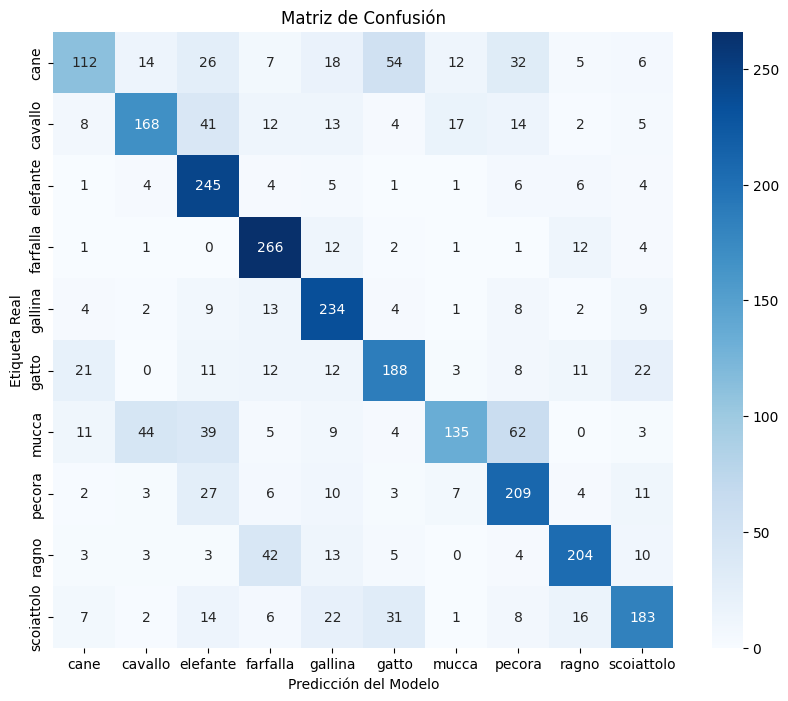

In [78]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las etiquetas verdaderas y las predicciones
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generar el Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generar la Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()



# Analizando el entrenamiento

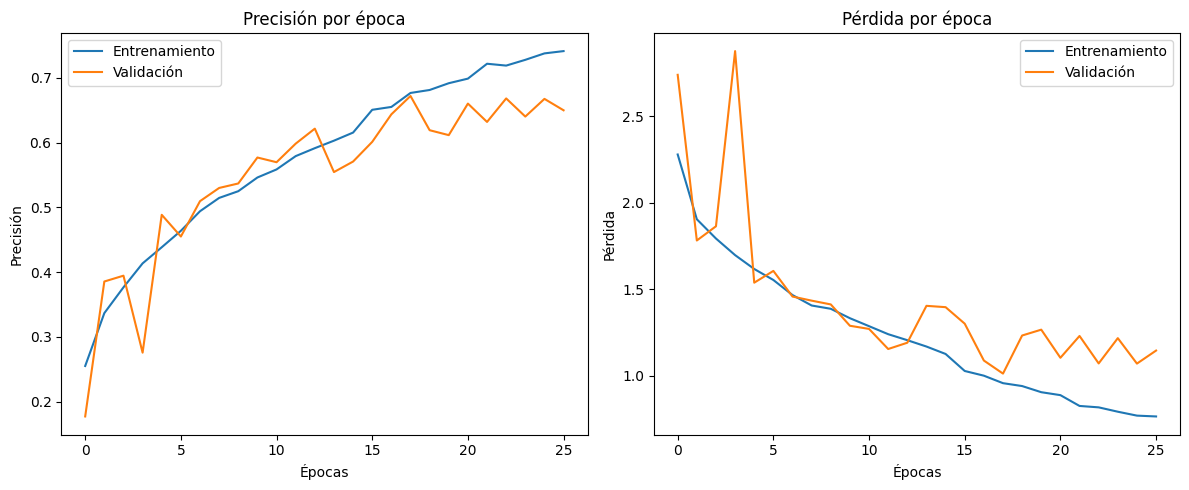

In [79]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()


plt.tight_layout()
plt.show()



In [84]:
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.models import Sequential


# ---------- MODELO ------------------------------------------------------
num_classes = len(class_names)


model_v2 = Sequential([
    # Bloque 1
    layers.Conv2D(32, (5, 5), activation='relu', padding='same',
                  input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Bloque 2
    layers.Conv2D(64, (5, 5), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Bloque 3
    layers.Conv2D(64, (5, 5), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Bloque 4
    layers.Conv2D(128, (5, 5), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Bloque 5
    layers.Conv2D(128, (5, 5), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Bloque 6
    layers.Conv2D(256, (5, 5), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_v2.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


model_v2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_v2 = model_v2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

Epoch 1/50
 10/362 [..............................] - ETA: 27s - loss: 3.1740 - accuracy: 0.1469

2025-06-17 19:44:23.178669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/362 [====>.........................] - ETA: 22s - loss: 2.8923 - accuracy: 0.1866

2025-06-17 19:44:27.844676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/362 [=====>........................] - ETA: 22s - loss: 2.8878 - accuracy: 0.1884

2025-06-17 19:44:28.057606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/362 [=====>........................] - ETA: 21s - loss: 2.8695 - accuracy: 0.1931

2025-06-17 19:44:28.832761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/362 [===========>..................] - ETA: 16s - loss: 2.7380 - accuracy: 0.2246

2025-06-17 19:44:34.058685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/362 [============>.................] - ETA: 15s - loss: 2.7181 - accuracy: 0.2303

2025-06-17 19:44:35.087583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/362 [================>.............] - ETA: 11s - loss: 2.6588 - accuracy: 0.2497

2025-06-17 19:44:39.193082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/362 [==================>...........] - ETA: 9s - loss: 2.6384 - accuracy: 0.2565 

2025-06-17 19:44:40.599922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/362 [===================>..........] - ETA: 9s - loss: 2.6309 - accuracy: 0.2580

2025-06-17 19:44:41.501239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


317/362 [=========================>....] - ETA: 3s - loss: 2.5765 - accuracy: 0.2731

2025-06-17 19:44:46.999404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:44:47.051934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


340/362 [===========================>..] - ETA: 1s - loss: 2.5556 - accuracy: 0.2798

2025-06-17 19:44:48.870051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - ETA: 0s - loss: 2.5373 - accuracy: 0.2866

2025-06-17 19:44:51.642809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:44:52.415297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 34s 86ms/step - loss: 2.5373 - accuracy: 0.2866 - val_loss: 3.1341 - val_accuracy: 0.1297 - lr: 1.0000e-04
Epoch 2/50
 24/362 [>.............................] - ETA: 26s - loss: 2.2276 - accuracy: 0.3932

2025-06-17 19:44:55.373861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/362 [=>............................] - ETA: 25s - loss: 2.2256 - accuracy: 0.3920

2025-06-17 19:44:56.178284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/362 [=======>......................] - ETA: 20s - loss: 2.2225 - accuracy: 0.3829

2025-06-17 19:45:01.215238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/362 [===========>..................] - ETA: 16s - loss: 2.2064 - accuracy: 0.3943

2025-06-17 19:45:05.499093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/362 [==============>...............] - ETA: 14s - loss: 2.1969 - accuracy: 0.3974

2025-06-17 19:45:07.602530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/362 [===============>..............] - ETA: 12s - loss: 2.1991 - accuracy: 0.3953

2025-06-17 19:45:09.324018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/362 [=================>............] - ETA: 10s - loss: 2.1910 - accuracy: 0.3965

2025-06-17 19:45:10.996345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/362 [==================>...........] - ETA: 9s - loss: 2.1837 - accuracy: 0.3994

2025-06-17 19:45:11.975190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/362 [====================>.........] - ETA: 8s - loss: 2.1702 - accuracy: 0.4059

2025-06-17 19:45:13.466647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/362 [======================>.......] - ETA: 6s - loss: 2.1604 - accuracy: 0.4113

2025-06-17 19:45:15.175774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


326/362 [==========================>...] - ETA: 2s - loss: 2.1459 - accuracy: 0.4179

2025-06-17 19:45:18.924337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


329/362 [==========================>...] - ETA: 2s - loss: 2.1454 - accuracy: 0.4178

2025-06-17 19:45:19.175020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 2.1320 - accuracy: 0.4222

2025-06-17 19:45:21.908617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:45:22.673952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 2.1323 - accuracy: 0.4221 - val_loss: 2.2068 - val_accuracy: 0.4232 - lr: 1.0000e-04
Epoch 3/50
  6/362 [..............................] - ETA: 29s - loss: 2.0352 - accuracy: 0.4531

2025-06-17 19:45:23.973628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/362 [=>............................] - ETA: 27s - loss: 2.0308 - accuracy: 0.4558

2025-06-17 19:45:25.816082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/362 [====>.........................] - ETA: 23s - loss: 1.9883 - accuracy: 0.4810

2025-06-17 19:45:28.557509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/362 [====>.........................] - ETA: 23s - loss: 1.9848 - accuracy: 0.4801

2025-06-17 19:45:28.952973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/362 [======>.......................] - ETA: 21s - loss: 1.9930 - accuracy: 0.4786

2025-06-17 19:45:30.754576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/362 [=========>....................] - ETA: 19s - loss: 1.9841 - accuracy: 0.4823

2025-06-17 19:45:33.082067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/362 [==========>...................] - ETA: 17s - loss: 1.9823 - accuracy: 0.4792

2025-06-17 19:45:34.652004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/362 [=================>............] - ETA: 11s - loss: 1.9653 - accuracy: 0.4802

2025-06-17 19:45:40.976207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


317/362 [=========================>....] - ETA: 3s - loss: 1.9541 - accuracy: 0.4873

2025-06-17 19:45:48.354819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:45:48.387112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:45:48.437121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


346/362 [===========================>..] - ETA: 1s - loss: 1.9467 - accuracy: 0.4900

2025-06-17 19:45:50.664594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.9417 - accuracy: 0.4919

2025-06-17 19:45:52.033111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:45:52.837178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.9422 - accuracy: 0.4919 - val_loss: 2.3574 - val_accuracy: 0.3897 - lr: 1.0000e-04
Epoch 4/50
 41/362 [==>...........................] - ETA: 25s - loss: 1.8964 - accuracy: 0.5160

2025-06-17 19:45:56.888357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/362 [==>...........................] - ETA: 24s - loss: 1.8897 - accuracy: 0.5163

2025-06-17 19:45:57.448535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/362 [===>..........................] - ETA: 23s - loss: 1.8937 - accuracy: 0.5145

2025-06-17 19:45:58.210598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/362 [=======>......................] - ETA: 20s - loss: 1.8752 - accuracy: 0.5202

2025-06-17 19:46:01.373648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/362 [=========>....................] - ETA: 18s - loss: 1.8677 - accuracy: 0.5257

2025-06-17 19:46:03.374778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/362 [============>.................] - ETA: 15s - loss: 1.8596 - accuracy: 0.5273

2025-06-17 19:46:06.126105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/362 [==============>...............] - ETA: 14s - loss: 1.8515 - accuracy: 0.5290

2025-06-17 19:46:07.819542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/362 [====================>.........] - ETA: 8s - loss: 1.8443 - accuracy: 0.5320

2025-06-17 19:46:13.684559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/362 [=====================>........] - ETA: 6s - loss: 1.8392 - accuracy: 0.5345

2025-06-17 19:46:15.272426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/362 [=========================>....] - ETA: 3s - loss: 1.8290 - accuracy: 0.5364

2025-06-17 19:46:18.721420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


340/362 [===========================>..] - ETA: 1s - loss: 1.8277 - accuracy: 0.5358

2025-06-17 19:46:20.208931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


353/362 [============================>.] - ETA: 0s - loss: 1.8244 - accuracy: 0.5365

2025-06-17 19:46:21.272541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.8233 - accuracy: 0.5374

2025-06-17 19:46:22.115865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:46:22.929305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.8234 - accuracy: 0.5375 - val_loss: 2.0480 - val_accuracy: 0.4803 - lr: 1.0000e-04
Epoch 5/50
  2/362 [..............................] - ETA: 29s - loss: 1.8095 - accuracy: 0.5156

2025-06-17 19:46:23.880705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/362 [=====>........................] - ETA: 22s - loss: 1.7398 - accuracy: 0.5541

2025-06-17 19:46:29.555640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/362 [========>.....................] - ETA: 19s - loss: 1.7306 - accuracy: 0.5622

2025-06-17 19:46:32.370341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/362 [==========>...................] - ETA: 17s - loss: 1.7249 - accuracy: 0.5623

2025-06-17 19:46:34.155210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/362 [==========>...................] - ETA: 17s - loss: 1.7227 - accuracy: 0.5638

2025-06-17 19:46:34.631178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/362 [===========>..................] - ETA: 16s - loss: 1.7220 - accuracy: 0.5627

2025-06-17 19:46:35.495128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/362 [============>.................] - ETA: 15s - loss: 1.7163 - accuracy: 0.5650

2025-06-17 19:46:36.586372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/362 [==============>...............] - ETA: 14s - loss: 1.7205 - accuracy: 0.5647

2025-06-17 19:46:37.978992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/362 [=================>............] - ETA: 10s - loss: 1.7269 - accuracy: 0.5632

2025-06-17 19:46:41.204404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/362 [====================>.........] - ETA: 7s - loss: 1.7274 - accuracy: 0.5616

2025-06-17 19:46:44.424875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:46:44.436191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/362 [=====================>........] - ETA: 6s - loss: 1.7258 - accuracy: 0.5622

2025-06-17 19:46:45.302578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.7125 - accuracy: 0.5668

2025-06-17 19:46:52.239275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:46:53.029681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.7126 - accuracy: 0.5668 - val_loss: 2.0365 - val_accuracy: 0.4758 - lr: 1.0000e-04
Epoch 6/50
  2/362 [..............................] - ETA: 28s - loss: 1.5769 - accuracy: 0.6875

2025-06-17 19:46:53.977378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/362 [>.............................] - ETA: 27s - loss: 1.6346 - accuracy: 0.6222

2025-06-17 19:46:55.614938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/362 [==>...........................] - ETA: 25s - loss: 1.6263 - accuracy: 0.6113

2025-06-17 19:46:57.113340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/362 [====>.........................] - ETA: 23s - loss: 1.6159 - accuracy: 0.6069

2025-06-17 19:46:59.278010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/362 [=========>....................] - ETA: 18s - loss: 1.6232 - accuracy: 0.6036

2025-06-17 19:47:03.343766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/362 [===========>..................] - ETA: 16s - loss: 1.6211 - accuracy: 0.6039

2025-06-17 19:47:05.924590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/362 [=============>................] - ETA: 14s - loss: 1.6240 - accuracy: 0.6015

2025-06-17 19:47:07.425930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/362 [===============>..............] - ETA: 12s - loss: 1.6138 - accuracy: 0.6064

2025-06-17 19:47:09.695850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/362 [====================>.........] - ETA: 7s - loss: 1.6100 - accuracy: 0.6096

2025-06-17 19:47:14.405088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


284/362 [======================>.......] - ETA: 6s - loss: 1.6119 - accuracy: 0.6077

2025-06-17 19:47:16.127269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


322/362 [=========================>....] - ETA: 3s - loss: 1.6148 - accuracy: 0.6072

2025-06-17 19:47:19.084731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


329/362 [==========================>...] - ETA: 2s - loss: 1.6159 - accuracy: 0.6065

2025-06-17 19:47:19.616429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.6158 - accuracy: 0.6067

2025-06-17 19:47:22.340639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:47:23.149193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.6157 - accuracy: 0.6068 - val_loss: 1.8037 - val_accuracy: 0.5553 - lr: 1.0000e-04
Epoch 7/50
 27/362 [=>............................] - ETA: 26s - loss: 1.5337 - accuracy: 0.6354

2025-06-17 19:47:26.127216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/362 [=>............................] - ETA: 26s - loss: 1.5450 - accuracy: 0.6250

2025-06-17 19:47:26.502216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/362 [===>..........................] - ETA: 24s - loss: 1.5875 - accuracy: 0.6097

2025-06-17 19:47:27.829280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/362 [====>.........................] - ETA: 23s - loss: 1.5659 - accuracy: 0.6199

2025-06-17 19:47:29.365303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/362 [======>.......................] - ETA: 21s - loss: 1.5576 - accuracy: 0.6181

2025-06-17 19:47:31.147703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/362 [=======>......................] - ETA: 20s - loss: 1.5620 - accuracy: 0.6207

2025-06-17 19:47:31.935434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/362 [========>.....................] - ETA: 19s - loss: 1.5670 - accuracy: 0.6145

2025-06-17 19:47:32.642728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/362 [=============>................] - ETA: 14s - loss: 1.5519 - accuracy: 0.6227

2025-06-17 19:47:37.622776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/362 [==================>...........] - ETA: 9s - loss: 1.5502 - accuracy: 0.6260

2025-06-17 19:47:42.767777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/362 [=====================>........] - ETA: 7s - loss: 1.5469 - accuracy: 0.6274

2025-06-17 19:47:45.113729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


304/362 [========================>.....] - ETA: 4s - loss: 1.5415 - accuracy: 0.6297

2025-06-17 19:47:47.848448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:47:47.860142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.5458 - accuracy: 0.6273

2025-06-17 19:47:52.508405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:47:53.292832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.5455 - accuracy: 0.6273 - val_loss: 2.0036 - val_accuracy: 0.5183 - lr: 1.0000e-04
Epoch 8/50
 16/362 [>.............................] - ETA: 27s - loss: 1.6068 - accuracy: 0.6152

2025-06-17 19:47:55.312985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/362 [===>..........................] - ETA: 24s - loss: 1.4871 - accuracy: 0.6582

2025-06-17 19:47:57.943288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:47:58.011473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/362 [====>.........................] - ETA: 23s - loss: 1.4644 - accuracy: 0.6583

2025-06-17 19:47:58.873032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/362 [====>.........................] - ETA: 22s - loss: 1.4821 - accuracy: 0.6528

2025-06-17 19:47:59.723335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/362 [=====>........................] - ETA: 21s - loss: 1.4847 - accuracy: 0.6547

2025-06-17 19:48:00.420058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/362 [======>.......................] - ETA: 20s - loss: 1.4781 - accuracy: 0.6579

2025-06-17 19:48:01.524100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/362 [========>.....................] - ETA: 19s - loss: 1.4733 - accuracy: 0.6576

2025-06-17 19:48:02.828767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/362 [========>.....................] - ETA: 19s - loss: 1.4726 - accuracy: 0.6573

2025-06-17 19:48:03.143583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/362 [===========>..................] - ETA: 16s - loss: 1.4671 - accuracy: 0.6543

2025-06-17 19:48:05.645154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/362 [============>.................] - ETA: 15s - loss: 1.4642 - accuracy: 0.6545

2025-06-17 19:48:06.589700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


311/362 [========================>.....] - ETA: 3s - loss: 1.4685 - accuracy: 0.6512

2025-06-17 19:48:18.418174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.4666 - accuracy: 0.6534

2025-06-17 19:48:22.610735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:48:23.387670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.4664 - accuracy: 0.6534 - val_loss: 1.8456 - val_accuracy: 0.5387 - lr: 1.0000e-04
Epoch 9/50
 14/362 [>.............................] - ETA: 28s - loss: 1.4721 - accuracy: 0.6518

2025-06-17 19:48:25.330304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:48:25.522461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/362 [==>...........................] - ETA: 25s - loss: 1.3855 - accuracy: 0.6680

2025-06-17 19:48:27.387064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/362 [===>..........................] - ETA: 24s - loss: 1.4079 - accuracy: 0.6579

2025-06-17 19:48:28.754055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:48:28.833286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/362 [======>.......................] - ETA: 21s - loss: 1.4016 - accuracy: 0.6677

2025-06-17 19:48:31.320306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/362 [============>.................] - ETA: 16s - loss: 1.4129 - accuracy: 0.6648

2025-06-17 19:48:36.634717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/362 [============>.................] - ETA: 15s - loss: 1.4093 - accuracy: 0.6663

2025-06-17 19:48:36.930257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/362 [=============>................] - ETA: 15s - loss: 1.4108 - accuracy: 0.6659

2025-06-17 19:48:37.489062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/362 [===================>..........] - ETA: 9s - loss: 1.4173 - accuracy: 0.6667

2025-06-17 19:48:43.540937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


321/362 [=========================>....] - ETA: 3s - loss: 1.4128 - accuracy: 0.6683

2025-06-17 19:48:49.449724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


344/362 [===========================>..] - ETA: 1s - loss: 1.4112 - accuracy: 0.6686

2025-06-17 19:48:51.239394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.4112 - accuracy: 0.6685

2025-06-17 19:48:52.811549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:48:53.576230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.4118 - accuracy: 0.6680 - val_loss: 1.7710 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 10/50
 59/362 [===>..........................] - ETA: 23s - loss: 1.3737 - accuracy: 0.6901

2025-06-17 19:48:59.059317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/362 [========>.....................] - ETA: 19s - loss: 1.3873 - accuracy: 0.6867

2025-06-17 19:49:03.820148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:49:03.972256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/362 [=========>....................] - ETA: 18s - loss: 1.3911 - accuracy: 0.6852

2025-06-17 19:49:04.060632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/362 [===========>..................] - ETA: 16s - loss: 1.3824 - accuracy: 0.6849

2025-06-17 19:49:06.481863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:49:06.649836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/362 [==============>...............] - ETA: 14s - loss: 1.3879 - accuracy: 0.6831

2025-06-17 19:49:08.784580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:49:08.946308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/362 [=================>............] - ETA: 11s - loss: 1.3774 - accuracy: 0.6858

2025-06-17 19:49:11.767252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/362 [====================>.........] - ETA: 8s - loss: 1.3755 - accuracy: 0.6850

2025-06-17 19:49:14.389457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


335/362 [==========================>...] - ETA: 2s - loss: 1.3669 - accuracy: 0.6867

2025-06-17 19:49:20.648093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


357/362 [============================>.] - ETA: 0s - loss: 1.3683 - accuracy: 0.6853

2025-06-17 19:49:22.391385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.3674 - accuracy: 0.6855

2025-06-17 19:49:22.929233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:49:23.727845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.3683 - accuracy: 0.6852 - val_loss: 1.7982 - val_accuracy: 0.5657 - lr: 1.0000e-04
Epoch 11/50
  6/362 [..............................] - ETA: 29s - loss: 1.3335 - accuracy: 0.6823

2025-06-17 19:49:25.088162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/362 [==>...........................] - ETA: 25s - loss: 1.3114 - accuracy: 0.6791

2025-06-17 19:49:27.575136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/362 [======>.......................] - ETA: 21s - loss: 1.3116 - accuracy: 0.6918

2025-06-17 19:49:31.507793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/362 [===========>..................] - ETA: 16s - loss: 1.3097 - accuracy: 0.7012

2025-06-17 19:49:36.816401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/362 [=============>................] - ETA: 14s - loss: 1.3001 - accuracy: 0.7055

2025-06-17 19:49:38.406641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/362 [===============>..............] - ETA: 13s - loss: 1.3003 - accuracy: 0.7062

2025-06-17 19:49:40.036549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:49:40.122019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/362 [================>.............] - ETA: 11s - loss: 1.3023 - accuracy: 0.7054

2025-06-17 19:49:41.392226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/362 [================>.............] - ETA: 11s - loss: 1.3028 - accuracy: 0.7052

2025-06-17 19:49:41.617695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/362 [=================>............] - ETA: 11s - loss: 1.3076 - accuracy: 0.7044

2025-06-17 19:49:41.930838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/362 [=====================>........] - ETA: 7s - loss: 1.3121 - accuracy: 0.7039

2025-06-17 19:49:45.692327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


315/362 [=========================>....] - ETA: 3s - loss: 1.3161 - accuracy: 0.7004

2025-06-17 19:49:49.367495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.3136 - accuracy: 0.7026

2025-06-17 19:49:53.187680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:49:53.967486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.3136 - accuracy: 0.7025 - val_loss: 1.5586 - val_accuracy: 0.6245 - lr: 1.0000e-04
Epoch 12/50
 83/362 [=====>........................] - ETA: 21s - loss: 1.2473 - accuracy: 0.7240

2025-06-17 19:50:01.279919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/362 [=========>....................] - ETA: 18s - loss: 1.2473 - accuracy: 0.7219

2025-06-17 19:50:04.790841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/362 [============>.................] - ETA: 15s - loss: 1.2392 - accuracy: 0.7257

2025-06-17 19:50:07.187927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/362 [=============>................] - ETA: 15s - loss: 1.2491 - accuracy: 0.7221

2025-06-17 19:50:08.037703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/362 [==============>...............] - ETA: 13s - loss: 1.2476 - accuracy: 0.7240

2025-06-17 19:50:09.400712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/362 [==============>...............] - ETA: 13s - loss: 1.2503 - accuracy: 0.7237

2025-06-17 19:50:09.794458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/362 [=================>............] - ETA: 10s - loss: 1.2549 - accuracy: 0.7225

2025-06-17 19:50:12.636597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/362 [===================>..........] - ETA: 9s - loss: 1.2548 - accuracy: 0.7213

2025-06-17 19:50:14.224003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/362 [====================>.........] - ETA: 8s - loss: 1.2562 - accuracy: 0.7214

2025-06-17 19:50:15.003961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/362 [=====================>........] - ETA: 7s - loss: 1.2607 - accuracy: 0.7205

2025-06-17 19:50:15.852566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


325/362 [=========================>....] - ETA: 2s - loss: 1.2596 - accuracy: 0.7169

2025-06-17 19:50:20.362101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


351/362 [============================>.] - ETA: 0s - loss: 1.2640 - accuracy: 0.7155

2025-06-17 19:50:22.421964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.2662 - accuracy: 0.7153

2025-06-17 19:50:23.434161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:50:24.205431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.2664 - accuracy: 0.7152 - val_loss: 1.4512 - val_accuracy: 0.6566 - lr: 1.0000e-04
Epoch 13/50
 27/362 [=>............................] - ETA: 26s - loss: 1.1557 - accuracy: 0.7546

2025-06-17 19:50:27.254863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/362 [====>.........................] - ETA: 23s - loss: 1.1912 - accuracy: 0.7413

2025-06-17 19:50:29.965914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/362 [=========>....................] - ETA: 18s - loss: 1.2337 - accuracy: 0.7257

2025-06-17 19:50:34.959141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/362 [==========>...................] - ETA: 17s - loss: 1.2336 - accuracy: 0.7244

2025-06-17 19:50:36.412555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/362 [===========>..................] - ETA: 16s - loss: 1.2298 - accuracy: 0.7251

2025-06-17 19:50:37.032063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/362 [==============>...............] - ETA: 14s - loss: 1.2208 - accuracy: 0.7282

2025-06-17 19:50:39.371896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/362 [===============>..............] - ETA: 13s - loss: 1.2223 - accuracy: 0.7270

2025-06-17 19:50:40.476875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/362 [===================>..........] - ETA: 8s - loss: 1.2269 - accuracy: 0.7265

2025-06-17 19:50:44.955617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:50:45.034649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


335/362 [==========================>...] - ETA: 2s - loss: 1.2235 - accuracy: 0.7271

2025-06-17 19:50:51.396775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:50:51.556182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


353/362 [============================>.] - ETA: 0s - loss: 1.2215 - accuracy: 0.7281

2025-06-17 19:50:52.813034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.2218 - accuracy: 0.7278

2025-06-17 19:50:53.662400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:50:54.429206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.2226 - accuracy: 0.7277 - val_loss: 1.6348 - val_accuracy: 0.6138 - lr: 1.0000e-04
Epoch 14/50
 26/362 [=>............................] - ETA: 27s - loss: 1.1981 - accuracy: 0.7392

2025-06-17 19:50:57.330740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:50:57.490263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/362 [========>.....................] - ETA: 19s - loss: 1.1679 - accuracy: 0.7421

2025-06-17 19:51:04.646159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/362 [==========>...................] - ETA: 17s - loss: 1.1810 - accuracy: 0.7365

2025-06-17 19:51:06.598756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/362 [===========>..................] - ETA: 16s - loss: 1.1800 - accuracy: 0.7369

2025-06-17 19:51:07.308907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/362 [=============>................] - ETA: 14s - loss: 1.1768 - accuracy: 0.7392

2025-06-17 19:51:09.103689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/362 [==============>...............] - ETA: 14s - loss: 1.1767 - accuracy: 0.7390

2025-06-17 19:51:09.537301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/362 [==================>...........] - ETA: 10s - loss: 1.1808 - accuracy: 0.7378

2025-06-17 19:51:13.328848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/362 [==================>...........] - ETA: 9s - loss: 1.1818 - accuracy: 0.7385

2025-06-17 19:51:13.849163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:51:13.928626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


295/362 [=======================>......] - ETA: 5s - loss: 1.1891 - accuracy: 0.7368

2025-06-17 19:51:18.457620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


342/362 [===========================>..] - ETA: 1s - loss: 1.1921 - accuracy: 0.7349

2025-06-17 19:51:22.131271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.1886 - accuracy: 0.7356

2025-06-17 19:51:23.827164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:51:24.595430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.1896 - accuracy: 0.7353 - val_loss: 1.7871 - val_accuracy: 0.5723 - lr: 1.0000e-04
Epoch 15/50
  6/362 [..............................] - ETA: 29s - loss: 1.0903 - accuracy: 0.7552

2025-06-17 19:51:25.876512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/362 [>.............................] - ETA: 28s - loss: 1.1462 - accuracy: 0.7620

2025-06-17 19:51:26.459446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/362 [==>...........................] - ETA: 25s - loss: 1.1771 - accuracy: 0.7426

2025-06-17 19:51:28.415400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/362 [==============>...............] - ETA: 14s - loss: 1.1565 - accuracy: 0.7498

2025-06-17 19:51:39.910030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/362 [===============>..............] - ETA: 12s - loss: 1.1546 - accuracy: 0.7511

2025-06-17 19:51:41.111722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/362 [================>.............] - ETA: 11s - loss: 1.1565 - accuracy: 0.7510

2025-06-17 19:51:42.449200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/362 [=====================>........] - ETA: 6s - loss: 1.1623 - accuracy: 0.7458

2025-06-17 19:51:46.989353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/362 [======================>.......] - ETA: 6s - loss: 1.1616 - accuracy: 0.7460

2025-06-17 19:51:47.316255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/362 [======================>.......] - ETA: 6s - loss: 1.1607 - accuracy: 0.7463

2025-06-17 19:51:47.619648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


329/362 [==========================>...] - ETA: 2s - loss: 1.1516 - accuracy: 0.7491

2025-06-17 19:51:51.295501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:51:51.367934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


342/362 [===========================>..] - ETA: 1s - loss: 1.1522 - accuracy: 0.7488

2025-06-17 19:51:52.292613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.1532 - accuracy: 0.7475

2025-06-17 19:51:54.023123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:51:54.797815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.1534 - accuracy: 0.7474 - val_loss: 1.3637 - val_accuracy: 0.6895 - lr: 1.0000e-04
Epoch 16/50
 24/362 [>.............................] - ETA: 27s - loss: 1.1225 - accuracy: 0.7682

2025-06-17 19:51:57.568411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:51:57.622204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/362 [===>..........................] - ETA: 24s - loss: 1.1114 - accuracy: 0.7651

2025-06-17 19:52:00.072046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/362 [====>.........................] - ETA: 23s - loss: 1.1169 - accuracy: 0.7652

2025-06-17 19:52:00.985308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/362 [=====>........................] - ETA: 22s - loss: 1.1131 - accuracy: 0.7665

2025-06-17 19:52:01.466155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/362 [=====>........................] - ETA: 22s - loss: 1.1090 - accuracy: 0.7687

2025-06-17 19:52:02.105471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:52:02.110978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


288/362 [======================>.......] - ETA: 5s - loss: 1.1164 - accuracy: 0.7648

2025-06-17 19:52:18.211358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


295/362 [=======================>......] - ETA: 5s - loss: 1.1194 - accuracy: 0.7638

2025-06-17 19:52:18.782227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


314/362 [=========================>....] - ETA: 3s - loss: 1.1181 - accuracy: 0.7641

2025-06-17 19:52:20.266247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


318/362 [=========================>....] - ETA: 3s - loss: 1.1181 - accuracy: 0.7635

2025-06-17 19:52:20.567266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


323/362 [=========================>....] - ETA: 3s - loss: 1.1170 - accuracy: 0.7636

2025-06-17 19:52:20.976926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.1170 - accuracy: 0.7649

2025-06-17 19:52:24.151757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:52:24.946960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.1166 - accuracy: 0.7649 - val_loss: 1.3440 - val_accuracy: 0.7012 - lr: 1.0000e-04
Epoch 17/50
132/362 [=========>....................] - ETA: 18s - loss: 1.0815 - accuracy: 0.7656

2025-06-17 19:52:36.224685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/362 [==========>...................] - ETA: 17s - loss: 1.0849 - accuracy: 0.7663

2025-06-17 19:52:37.017499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/362 [=============>................] - ETA: 14s - loss: 1.0954 - accuracy: 0.7623

2025-06-17 19:52:39.811851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/362 [==============>...............] - ETA: 13s - loss: 1.1008 - accuracy: 0.7618

2025-06-17 19:52:40.427006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/362 [================>.............] - ETA: 12s - loss: 1.0998 - accuracy: 0.7632

2025-06-17 19:52:42.277261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/362 [==================>...........] - ETA: 10s - loss: 1.0959 - accuracy: 0.7655

2025-06-17 19:52:44.150455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/362 [===================>..........] - ETA: 9s - loss: 1.0971 - accuracy: 0.7657

2025-06-17 19:52:45.053587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


287/362 [======================>.......] - ETA: 5s - loss: 1.0881 - accuracy: 0.7679

2025-06-17 19:52:48.362499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


307/362 [========================>.....] - ETA: 4s - loss: 1.0826 - accuracy: 0.7703

2025-06-17 19:52:49.957321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


331/362 [==========================>...] - ETA: 2s - loss: 1.0878 - accuracy: 0.7693

2025-06-17 19:52:51.795144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


338/362 [===========================>..] - ETA: 1s - loss: 1.0889 - accuracy: 0.7694

2025-06-17 19:52:52.346042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


357/362 [============================>.] - ETA: 0s - loss: 1.0938 - accuracy: 0.7685

2025-06-17 19:52:53.826673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.0928 - accuracy: 0.7687

2025-06-17 19:52:54.372994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:52:55.165693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.0922 - accuracy: 0.7689 - val_loss: 1.7553 - val_accuracy: 0.5882 - lr: 1.0000e-04
Epoch 18/50
 17/362 [>.............................] - ETA: 27s - loss: 0.9801 - accuracy: 0.8033

2025-06-17 19:52:57.324995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/362 [>.............................] - ETA: 27s - loss: 0.9991 - accuracy: 0.8011

2025-06-17 19:52:57.699020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/362 [=====>........................] - ETA: 22s - loss: 1.0519 - accuracy: 0.7753

2025-06-17 19:53:01.702846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/362 [=========>....................] - ETA: 18s - loss: 1.0540 - accuracy: 0.7758

2025-06-17 19:53:05.442448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/362 [===========>..................] - ETA: 16s - loss: 1.0444 - accuracy: 0.7817

2025-06-17 19:53:08.186252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/362 [===============>..............] - ETA: 12s - loss: 1.0431 - accuracy: 0.7845

2025-06-17 19:53:11.790282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/362 [====================>.........] - ETA: 7s - loss: 1.0427 - accuracy: 0.7835

2025-06-17 19:53:16.405467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/362 [=====================>........] - ETA: 7s - loss: 1.0410 - accuracy: 0.7844

2025-06-17 19:53:16.870954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:53:16.954251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


301/362 [=======================>......] - ETA: 4s - loss: 1.0384 - accuracy: 0.7849

2025-06-17 19:53:19.553137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:53:19.706390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


356/362 [============================>.] - ETA: 0s - loss: 1.0473 - accuracy: 0.7812

2025-06-17 19:53:23.846246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.0466 - accuracy: 0.7816

2025-06-17 19:53:24.460028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:53:25.237645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.0473 - accuracy: 0.7813 - val_loss: 1.3839 - val_accuracy: 0.6898 - lr: 1.0000e-04
Epoch 19/50
 30/362 [=>............................] - ETA: 26s - loss: 1.0656 - accuracy: 0.7802

2025-06-17 19:53:28.430148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:53:28.606738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/362 [===>..........................] - ETA: 24s - loss: 1.0418 - accuracy: 0.7837

2025-06-17 19:53:30.022823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:53:30.079639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/362 [=========>....................] - ETA: 18s - loss: 1.0312 - accuracy: 0.7857

2025-06-17 19:53:35.876801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/362 [=========>....................] - ETA: 18s - loss: 1.0317 - accuracy: 0.7855

2025-06-17 19:53:36.402866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/362 [=============>................] - ETA: 15s - loss: 1.0238 - accuracy: 0.7890

2025-06-17 19:53:39.303710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/362 [==================>...........] - ETA: 9s - loss: 1.0173 - accuracy: 0.7918

2025-06-17 19:53:44.886463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/362 [====================>.........] - ETA: 7s - loss: 1.0183 - accuracy: 0.7912

2025-06-17 19:53:46.854377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:53:46.934046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


290/362 [=======================>......] - ETA: 5s - loss: 1.0192 - accuracy: 0.7903

2025-06-17 19:53:48.819726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


351/362 [============================>.] - ETA: 0s - loss: 1.0231 - accuracy: 0.7902

2025-06-17 19:53:53.681973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.0253 - accuracy: 0.7906

2025-06-17 19:53:54.682670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:53:55.447300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.0249 - accuracy: 0.7907 - val_loss: 1.1974 - val_accuracy: 0.7434 - lr: 1.0000e-04
Epoch 20/50
 50/362 [===>..........................] - ETA: 24s - loss: 0.9710 - accuracy: 0.8019

2025-06-17 19:54:00.256700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/362 [===>..........................] - ETA: 24s - loss: 0.9743 - accuracy: 0.7971

2025-06-17 19:54:00.828036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/362 [====>.........................] - ETA: 23s - loss: 0.9793 - accuracy: 0.7971

2025-06-17 19:54:01.621330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/362 [=======>......................] - ETA: 20s - loss: 0.9865 - accuracy: 0.7933

2025-06-17 19:54:04.661575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/362 [============>.................] - ETA: 15s - loss: 0.9960 - accuracy: 0.7969

2025-06-17 19:54:09.525551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/362 [==============>...............] - ETA: 14s - loss: 0.9914 - accuracy: 0.7977

2025-06-17 19:54:10.551803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/362 [=================>............] - ETA: 11s - loss: 0.9918 - accuracy: 0.7974

2025-06-17 19:54:13.427141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/362 [===================>..........] - ETA: 8s - loss: 0.9990 - accuracy: 0.7951

2025-06-17 19:54:15.936184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/362 [====================>.........] - ETA: 8s - loss: 0.9974 - accuracy: 0.7960

2025-06-17 19:54:16.493845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


289/362 [======================>.......] - ETA: 5s - loss: 1.0011 - accuracy: 0.7940

2025-06-17 19:54:19.025892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


302/362 [========================>.....] - ETA: 4s - loss: 1.0027 - accuracy: 0.7931

2025-06-17 19:54:20.034821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


356/362 [============================>.] - ETA: 0s - loss: 1.0023 - accuracy: 0.7927

2025-06-17 19:54:24.229437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.0025 - accuracy: 0.7929

2025-06-17 19:54:24.834624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:54:25.615881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 1.0023 - accuracy: 0.7931 - val_loss: 1.3691 - val_accuracy: 0.6936 - lr: 1.0000e-04
Epoch 21/50
  9/362 [..............................] - ETA: 28s - loss: 0.9445 - accuracy: 0.8160

2025-06-17 19:54:27.178068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/362 [>.............................] - ETA: 28s - loss: 0.9314 - accuracy: 0.8125

2025-06-17 19:54:27.568128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:54:27.644107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/362 [=====>........................] - ETA: 22s - loss: 0.9831 - accuracy: 0.8074

2025-06-17 19:54:32.733783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/362 [======>.......................] - ETA: 21s - loss: 0.9832 - accuracy: 0.8076

2025-06-17 19:54:33.448286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/362 [======>.......................] - ETA: 21s - loss: 0.9794 - accuracy: 0.8095

2025-06-17 19:54:33.829551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/362 [============>.................] - ETA: 15s - loss: 0.9782 - accuracy: 0.8050

2025-06-17 19:54:39.600981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/362 [==============>...............] - ETA: 13s - loss: 0.9786 - accuracy: 0.8064

2025-06-17 19:54:41.019409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/362 [================>.............] - ETA: 11s - loss: 0.9750 - accuracy: 0.8076

2025-06-17 19:54:42.988811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/362 [=================>............] - ETA: 10s - loss: 0.9774 - accuracy: 0.8068

2025-06-17 19:54:44.199570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


305/362 [========================>.....] - ETA: 4s - loss: 0.9841 - accuracy: 0.8040

2025-06-17 19:54:50.442220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


319/362 [=========================>....] - ETA: 3s - loss: 0.9817 - accuracy: 0.8043

2025-06-17 19:54:51.565147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.9801 - accuracy: 0.8049

2025-06-17 19:54:55.085329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:54:55.859220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 0.9798 - accuracy: 0.8051 - val_loss: 1.5910 - val_accuracy: 0.6515 - lr: 1.0000e-04
Epoch 22/50
 14/362 [>.............................] - ETA: 28s - loss: 0.9430 - accuracy: 0.8304

2025-06-17 19:54:57.822659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/362 [=====>........................] - ETA: 23s - loss: 0.9374 - accuracy: 0.8142

2025-06-17 19:55:02.495187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/362 [=====>........................] - ETA: 22s - loss: 0.9345 - accuracy: 0.8154

2025-06-17 19:55:02.731018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/362 [========>.....................] - ETA: 19s - loss: 0.9369 - accuracy: 0.8163

2025-06-17 19:55:05.931370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/362 [==========>...................] - ETA: 18s - loss: 0.9416 - accuracy: 0.8130

2025-06-17 19:55:07.492023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/362 [============>.................] - ETA: 16s - loss: 0.9470 - accuracy: 0.8131

2025-06-17 19:55:09.139915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:55:09.226291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/362 [===============>..............] - ETA: 12s - loss: 0.9432 - accuracy: 0.8147

2025-06-17 19:55:12.451797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/362 [================>.............] - ETA: 12s - loss: 0.9428 - accuracy: 0.8151

2025-06-17 19:55:13.059133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/362 [======================>.......] - ETA: 6s - loss: 0.9503 - accuracy: 0.8098

2025-06-17 19:55:18.765700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:55:18.813307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


337/362 [==========================>...] - ETA: 1s - loss: 0.9520 - accuracy: 0.8101

2025-06-17 19:55:23.286547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.9538 - accuracy: 0.8095

2025-06-17 19:55:25.372817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:55:26.139194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 0.9545 - accuracy: 0.8092 - val_loss: 1.4078 - val_accuracy: 0.6988 - lr: 1.0000e-04
Epoch 23/50
  3/362 [..............................] - ETA: 29s - loss: 0.9504 - accuracy: 0.7917

2025-06-17 19:55:27.188713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/362 [..............................] - ETA: 30s - loss: 0.9397 - accuracy: 0.7882

2025-06-17 19:55:27.682376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/362 [=>............................] - ETA: 27s - loss: 0.9267 - accuracy: 0.8090

2025-06-17 19:55:29.134096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/362 [===>..........................] - ETA: 24s - loss: 0.9101 - accuracy: 0.8220

2025-06-17 19:55:31.402522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/362 [=====>........................] - ETA: 22s - loss: 0.8799 - accuracy: 0.8348

2025-06-17 19:55:32.726559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/362 [======>.......................] - ETA: 21s - loss: 0.8734 - accuracy: 0.8396

2025-06-17 19:55:34.167154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/362 [===========>..................] - ETA: 16s - loss: 0.8599 - accuracy: 0.8433

2025-06-17 19:55:38.618866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/362 [==============>...............] - ETA: 13s - loss: 0.8633 - accuracy: 0.8426

2025-06-17 19:55:41.669728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/362 [===============>..............] - ETA: 13s - loss: 0.8604 - accuracy: 0.8441

2025-06-17 19:55:42.285611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/362 [==================>...........] - ETA: 10s - loss: 0.8627 - accuracy: 0.8421

2025-06-17 19:55:45.032608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/362 [===================>..........] - ETA: 9s - loss: 0.8643 - accuracy: 0.8412

2025-06-17 19:55:46.052107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/362 [=====================>........] - ETA: 7s - loss: 0.8646 - accuracy: 0.8410

2025-06-17 19:55:48.106202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.8709 - accuracy: 0.8392

2025-06-17 19:55:55.564590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:55:56.361892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 0.8709 - accuracy: 0.8392 - val_loss: 1.2925 - val_accuracy: 0.7206 - lr: 5.0000e-05
Epoch 24/50
 23/362 [>.............................] - ETA: 26s - loss: 0.8197 - accuracy: 0.8560

2025-06-17 19:55:59.005826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/362 [==>...........................] - ETA: 25s - loss: 0.8248 - accuracy: 0.8485

2025-06-17 19:56:00.809071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/362 [====>.........................] - ETA: 24s - loss: 0.8316 - accuracy: 0.8432

2025-06-17 19:56:02.031784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/362 [==================>...........] - ETA: 10s - loss: 0.8475 - accuracy: 0.8420

2025-06-17 19:56:15.502830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/362 [===================>..........] - ETA: 9s - loss: 0.8487 - accuracy: 0.8421

2025-06-17 19:56:16.588174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/362 [=====================>........] - ETA: 7s - loss: 0.8447 - accuracy: 0.8436

2025-06-17 19:56:18.223443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/362 [======================>.......] - ETA: 6s - loss: 0.8442 - accuracy: 0.8442

2025-06-17 19:56:19.414376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


309/362 [========================>.....] - ETA: 4s - loss: 0.8414 - accuracy: 0.8458

2025-06-17 19:56:21.588121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


315/362 [=========================>....] - ETA: 3s - loss: 0.8399 - accuracy: 0.8462

2025-06-17 19:56:22.071319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


330/362 [==========================>...] - ETA: 2s - loss: 0.8417 - accuracy: 0.8460

2025-06-17 19:56:23.249410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


336/362 [==========================>...] - ETA: 2s - loss: 0.8432 - accuracy: 0.8450

2025-06-17 19:56:23.713775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


360/362 [============================>.] - ETA: 0s - loss: 0.8443 - accuracy: 0.8445

2025-06-17 19:56:25.566118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.8440 - accuracy: 0.8447

2025-06-17 19:56:25.920869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:56:26.687463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 84ms/step - loss: 0.8437 - accuracy: 0.8448 - val_loss: 1.5720 - val_accuracy: 0.6674 - lr: 5.0000e-05
Epoch 25/50
 13/362 [>.............................] - ETA: 28s - loss: 0.7471 - accuracy: 0.8702

2025-06-17 19:56:28.581477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/362 [==>...........................] - ETA: 25s - loss: 0.7852 - accuracy: 0.8470

2025-06-17 19:56:30.528079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/362 [========>.....................] - ETA: 20s - loss: 0.8024 - accuracy: 0.8518

2025-06-17 19:56:36.111887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/362 [=========>....................] - ETA: 18s - loss: 0.8051 - accuracy: 0.8522

2025-06-17 19:56:37.133691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/362 [=========>....................] - ETA: 18s - loss: 0.8104 - accuracy: 0.8507

2025-06-17 19:56:37.826110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/362 [===============>..............] - ETA: 12s - loss: 0.8258 - accuracy: 0.8462

2025-06-17 19:56:43.625215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/362 [================>.............] - ETA: 12s - loss: 0.8261 - accuracy: 0.8460

2025-06-17 19:56:43.848222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/362 [==================>...........] - ETA: 10s - loss: 0.8213 - accuracy: 0.8478

2025-06-17 19:56:45.799482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/362 [====================>.........] - ETA: 7s - loss: 0.8216 - accuracy: 0.8488

2025-06-17 19:56:48.301147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/362 [=====================>........] - ETA: 6s - loss: 0.8241 - accuracy: 0.8483

2025-06-17 19:56:49.263633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


335/362 [==========================>...] - ETA: 2s - loss: 0.8217 - accuracy: 0.8497

2025-06-17 19:56:53.818745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


348/362 [===========================>..] - ETA: 1s - loss: 0.8213 - accuracy: 0.8497

2025-06-17 19:56:54.901469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.8206 - accuracy: 0.8505

2025-06-17 19:56:56.144834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:56:56.963887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 0.8213 - accuracy: 0.8503 - val_loss: 1.2375 - val_accuracy: 0.7521 - lr: 5.0000e-05
Epoch 26/50
 12/362 [..............................] - ETA: 28s - loss: 0.7938 - accuracy: 0.8542

2025-06-17 19:56:58.769175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/362 [>.............................] - ETA: 27s - loss: 0.8063 - accuracy: 0.8551

2025-06-17 19:56:59.547749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/362 [=========>....................] - ETA: 18s - loss: 0.7782 - accuracy: 0.8695

2025-06-17 19:57:08.152231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/362 [===========>..................] - ETA: 16s - loss: 0.7785 - accuracy: 0.8680

2025-06-17 19:57:09.715212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/362 [=============>................] - ETA: 15s - loss: 0.7783 - accuracy: 0.8680

2025-06-17 19:57:11.145067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/362 [==============>...............] - ETA: 14s - loss: 0.7815 - accuracy: 0.8665

2025-06-17 19:57:12.334329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/362 [===============>..............] - ETA: 13s - loss: 0.7826 - accuracy: 0.8660

2025-06-17 19:57:13.114435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/362 [================>.............] - ETA: 11s - loss: 0.7804 - accuracy: 0.8679

2025-06-17 19:57:14.545674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:57:14.701939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/362 [=================>............] - ETA: 11s - loss: 0.7797 - accuracy: 0.8683

2025-06-17 19:57:15.175636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/362 [===================>..........] - ETA: 8s - loss: 0.7817 - accuracy: 0.8676

2025-06-17 19:57:17.508894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


336/362 [==========================>...] - ETA: 2s - loss: 0.7851 - accuracy: 0.8673

2025-06-17 19:57:24.307413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.7858 - accuracy: 0.8677

2025-06-17 19:57:26.459923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:57:27.262504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 84ms/step - loss: 0.7857 - accuracy: 0.8677 - val_loss: 1.2095 - val_accuracy: 0.7445 - lr: 2.5000e-05
Epoch 27/50
 29/362 [=>............................] - ETA: 26s - loss: 0.7413 - accuracy: 0.8815

2025-06-17 19:57:30.413112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/362 [==>...........................] - ETA: 25s - loss: 0.7460 - accuracy: 0.8775

2025-06-17 19:57:31.061318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/362 [=====>........................] - ETA: 21s - loss: 0.7278 - accuracy: 0.8857

2025-06-17 19:57:34.516701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/362 [========>.....................] - ETA: 19s - loss: 0.7419 - accuracy: 0.8827

2025-06-17 19:57:37.245034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/362 [===========>..................] - ETA: 16s - loss: 0.7394 - accuracy: 0.8820

2025-06-17 19:57:39.613420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:57:39.663405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/362 [===========>..................] - ETA: 16s - loss: 0.7370 - accuracy: 0.8839

2025-06-17 19:57:40.213068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/362 [==================>...........] - ETA: 10s - loss: 0.7492 - accuracy: 0.8785

2025-06-17 19:57:46.196112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/362 [====================>.........] - ETA: 7s - loss: 0.7489 - accuracy: 0.8790

2025-06-17 19:57:48.576725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:57:48.668235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:57:48.740346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/362 [=====================>........] - ETA: 6s - loss: 0.7498 - accuracy: 0.8779

2025-06-17 19:57:49.829620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.7531 - accuracy: 0.8762

2025-06-17 19:57:56.620703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 19:57:57.399644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 30s 83ms/step - loss: 0.7534 - accuracy: 0.8761 - val_loss: 1.2617 - val_accuracy: 0.7389 - lr: 2.5000e-05


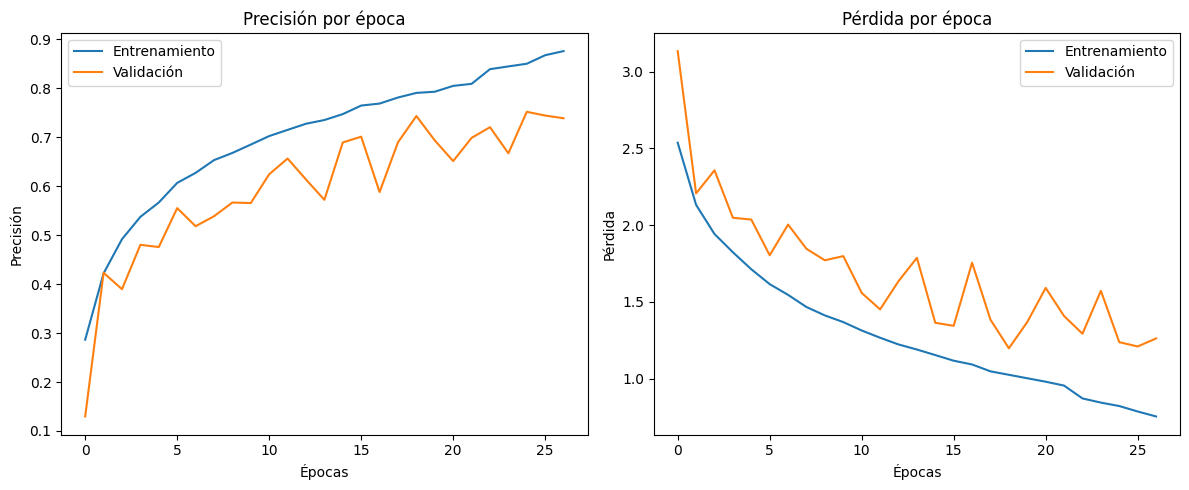

In [85]:
import matplotlib.pyplot as plt

acc = history_v2.history['accuracy']
val_acc = history_v2.history['val_accuracy']

loss = history_v2.history['loss']
val_loss = history_v2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()


plt.tight_layout()
plt.show()



2025-06-17 20:42:11.436647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:42:11.553581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/91 [==>...........................] - ETA: 1s

2025-06-17 20:42:11.808752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/91 [=================>............] - ETA: 0s

2025-06-17 20:42:12.537263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


91/91 [==============================] - 2s 17ms/step
Classification Report:
              precision    recall  f1-score   support

        cane       0.79      0.63      0.70       286
     cavallo       0.77      0.65      0.71       284
    elefante       0.65      0.90      0.75       277
    farfalla       0.67      0.94      0.78       300
     gallina       0.88      0.80      0.84       286
       gatto       0.76      0.69      0.72       288
       mucca       0.73      0.63      0.68       312
      pecora       0.74      0.68      0.71       282
       ragno       0.86      0.74      0.79       287
  scoiattolo       0.72      0.77      0.74       290

    accuracy                           0.74      2892
   macro avg       0.75      0.74      0.74      2892
weighted avg       0.75      0.74      0.74      2892



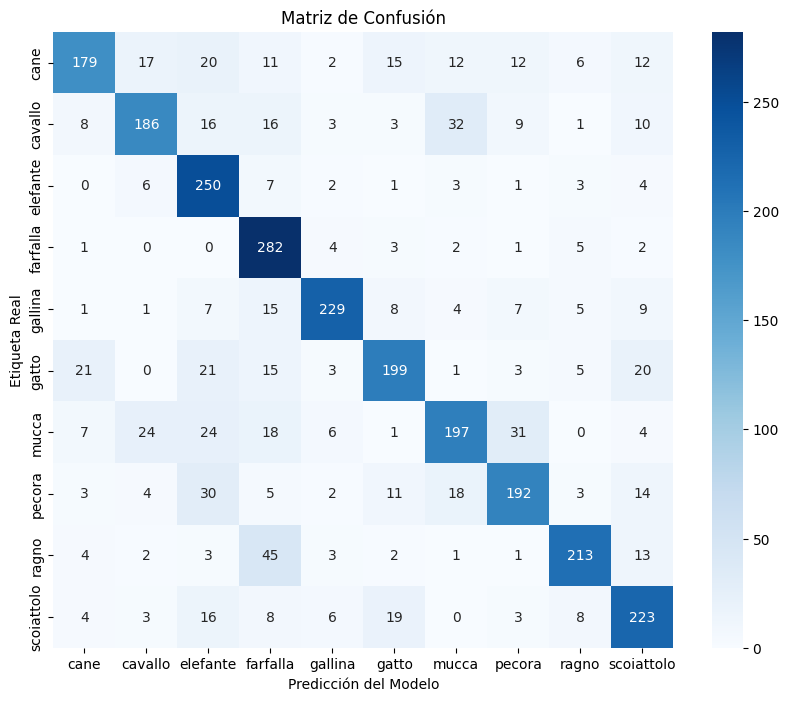

In [86]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las etiquetas verdaderas y las predicciones
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_probs = model_v2.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generar el Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generar la Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()



In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam


## 3. Modelo Pre-entrenado (Transfer Learning)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,  # No incluir la capa de clasificación original
    weights='imagenet'  # Usar pesos pre-entrenados en ImageNet
)

# Congelar las capas base (opcional, puedes descongelar algunas después)
base_model.trainable = False

## 4. Construcción del modelo completo
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # training=False para mantener BatchNorm en modo inferencia
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

## 5. Compilación con learning rate bajo
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## 6. Entrenamiento con callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # Más épocas porque el learning rate es bajo
    callbacks=callbacks
)





Epoch 1/20
 62/362 [====>.........................] - ETA: 14s - loss: 2.7751 - accuracy: 0.1285

2025-06-17 20:52:22.968472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/362 [======>.......................] - ETA: 12s - loss: 2.6886 - accuracy: 0.1478

2025-06-17 20:52:24.604049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/362 [==========>...................] - ETA: 10s - loss: 2.5429 - accuracy: 0.1816

2025-06-17 20:52:26.945511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/362 [============>.................] - ETA: 9s - loss: 2.4786 - accuracy: 0.1974

2025-06-17 20:52:28.206012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/362 [===================>..........] - ETA: 5s - loss: 2.2620 - accuracy: 0.2649

2025-06-17 20:52:32.358952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:52:32.442603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/362 [====================>.........] - ETA: 5s - loss: 2.2502 - accuracy: 0.2688

2025-06-17 20:52:32.587591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/362 [======================>.......] - ETA: 4s - loss: 2.1923 - accuracy: 0.2880

2025-06-17 20:52:33.796642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


294/362 [=======================>......] - ETA: 3s - loss: 2.1585 - accuracy: 0.2991

2025-06-17 20:52:34.597750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


347/362 [===========================>..] - ETA: 0s - loss: 2.0531 - accuracy: 0.3336

2025-06-17 20:52:37.255449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 2.0286 - accuracy: 0.3414

2025-06-17 20:52:38.111493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:52:38.157150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - ETA: 0s - loss: 2.0280 - accuracy: 0.3417

2025-06-17 20:52:39.392311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:52:40.707585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 24s 63ms/step - loss: 2.0280 - accuracy: 0.3417 - val_loss: 0.9445 - val_accuracy: 0.7804


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
 25/362 [=>............................] - ETA: 17s - loss: 1.2865 - accuracy: 0.6050

2025-06-17 20:52:43.951351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/362 [=>............................] - ETA: 17s - loss: 1.2886 - accuracy: 0.6045

2025-06-17 20:52:44.156356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/362 [==========>...................] - ETA: 11s - loss: 1.2443 - accuracy: 0.6165

2025-06-17 20:52:49.512695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/362 [============>.................] - ETA: 10s - loss: 1.2360 - accuracy: 0.6186

2025-06-17 20:52:50.670070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/362 [================>.............] - ETA: 7s - loss: 1.1962 - accuracy: 0.6304

2025-06-17 20:52:53.244252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/362 [=================>............] - ETA: 7s - loss: 1.1860 - accuracy: 0.6346

2025-06-17 20:52:54.104592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/362 [===================>..........] - ETA: 5s - loss: 1.1666 - accuracy: 0.6403

2025-06-17 20:52:55.393024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/362 [======================>.......] - ETA: 4s - loss: 1.1482 - accuracy: 0.6468

2025-06-17 20:52:57.042144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:52:57.055025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


326/362 [==========================>...] - ETA: 1s - loss: 1.1241 - accuracy: 0.6537

2025-06-17 20:52:59.233618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


349/362 [===========================>..] - ETA: 0s - loss: 1.1077 - accuracy: 0.6580

2025-06-17 20:53:00.420531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:53:00.553773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 1.1034 - accuracy: 0.6595

2025-06-17 20:53:01.181452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:53:02.507327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 21s 59ms/step - loss: 1.1037 - accuracy: 0.6593 - val_loss: 0.5398 - val_accuracy: 0.8696
Epoch 3/20
 28/362 [=>............................] - ETA: 16s - loss: 0.9364 - accuracy: 0.7020

2025-06-17 20:53:05.516315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/362 [==>...........................] - ETA: 15s - loss: 0.9254 - accuracy: 0.7116

2025-06-17 20:53:06.253073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:53:06.400822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/362 [===========>..................] - ETA: 10s - loss: 0.8877 - accuracy: 0.7242

2025-06-17 20:53:11.681960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/362 [==================>...........] - ETA: 6s - loss: 0.8677 - accuracy: 0.7294

2025-06-17 20:53:16.141671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/362 [===================>..........] - ETA: 5s - loss: 0.8669 - accuracy: 0.7297

2025-06-17 20:53:17.021629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/362 [====================>.........] - ETA: 5s - loss: 0.8653 - accuracy: 0.7304

2025-06-17 20:53:17.386402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/362 [=====================>........] - ETA: 4s - loss: 0.8606 - accuracy: 0.7315

2025-06-17 20:53:18.063823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


315/362 [=========================>....] - ETA: 2s - loss: 0.8455 - accuracy: 0.7374

2025-06-17 20:53:20.222288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


349/362 [===========================>..] - ETA: 0s - loss: 0.8326 - accuracy: 0.7418

2025-06-17 20:53:21.910752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


359/362 [============================>.] - ETA: 0s - loss: 0.8308 - accuracy: 0.7418

2025-06-17 20:53:22.476353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:53:22.588329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - ETA: 0s - loss: 0.8303 - accuracy: 0.7423

2025-06-17 20:53:22.842214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:53:24.188349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 22s 60ms/step - loss: 0.8303 - accuracy: 0.7423 - val_loss: 0.3966 - val_accuracy: 0.9098
Epoch 4/20
  4/362 [..............................] - ETA: 17s - loss: 0.7863 - accuracy: 0.7578

2025-06-17 20:53:25.898837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:53:25.952452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/362 [>.............................] - ETA: 17s - loss: 0.7215 - accuracy: 0.7674

2025-06-17 20:53:26.659751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/362 [==>...........................] - ETA: 15s - loss: 0.7335 - accuracy: 0.7609

2025-06-17 20:53:27.953421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/362 [====>.........................] - ETA: 14s - loss: 0.7476 - accuracy: 0.7592

2025-06-17 20:53:29.307827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/362 [=====>........................] - ETA: 14s - loss: 0.7422 - accuracy: 0.7600

2025-06-17 20:53:29.672679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/362 [========>.....................] - ETA: 12s - loss: 0.7416 - accuracy: 0.7600

2025-06-17 20:53:31.806558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/362 [=================>............] - ETA: 7s - loss: 0.7182 - accuracy: 0.7704

2025-06-17 20:53:36.908420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/362 [==================>...........] - ETA: 6s - loss: 0.7165 - accuracy: 0.7714

2025-06-17 20:53:37.756766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


308/362 [========================>.....] - ETA: 2s - loss: 0.7039 - accuracy: 0.7754

2025-06-17 20:53:41.229325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


330/362 [==========================>...] - ETA: 1s - loss: 0.7013 - accuracy: 0.7771

2025-06-17 20:53:42.328901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


348/362 [===========================>..] - ETA: 0s - loss: 0.6992 - accuracy: 0.7777

2025-06-17 20:53:43.250567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.6984 - accuracy: 0.7782

2025-06-17 20:53:44.142662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:53:45.466998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 21s 59ms/step - loss: 0.6981 - accuracy: 0.7784 - val_loss: 0.3338 - val_accuracy: 0.9174
Epoch 5/20
 30/362 [=>............................] - ETA: 18s - loss: 0.6826 - accuracy: 0.7760

2025-06-17 20:53:48.665886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/362 [==>...........................] - ETA: 17s - loss: 0.6587 - accuracy: 0.7921

2025-06-17 20:53:49.515263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/362 [===>..........................] - ETA: 16s - loss: 0.6473 - accuracy: 0.7951

2025-06-17 20:53:49.812509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/362 [========>.....................] - ETA: 12s - loss: 0.6395 - accuracy: 0.8007

2025-06-17 20:53:53.335759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/362 [============>.................] - ETA: 10s - loss: 0.6366 - accuracy: 0.8014

2025-06-17 20:53:55.442456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/362 [==================>...........] - ETA: 6s - loss: 0.6267 - accuracy: 0.8053

2025-06-17 20:53:59.459688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/362 [====================>.........] - ETA: 5s - loss: 0.6271 - accuracy: 0.8053

2025-06-17 20:54:00.291134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/362 [=====================>........] - ETA: 4s - loss: 0.6274 - accuracy: 0.8047

2025-06-17 20:54:00.923998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/362 [======================>.......] - ETA: 4s - loss: 0.6271 - accuracy: 0.8043

2025-06-17 20:54:01.479934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


326/362 [==========================>...] - ETA: 1s - loss: 0.6192 - accuracy: 0.8061

2025-06-17 20:54:03.829286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


338/362 [===========================>..] - ETA: 1s - loss: 0.6177 - accuracy: 0.8058

2025-06-17 20:54:04.491831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


346/362 [===========================>..] - ETA: 0s - loss: 0.6163 - accuracy: 0.8065

2025-06-17 20:54:04.795941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.8061

2025-06-17 20:54:05.757164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:54:07.085267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 22s 60ms/step - loss: 0.6166 - accuracy: 0.8061 - val_loss: 0.2950 - val_accuracy: 0.9302
Epoch 6/20
 40/362 [==>...........................] - ETA: 16s - loss: 0.6027 - accuracy: 0.8117

2025-06-17 20:54:10.641683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/362 [==>...........................] - ETA: 15s - loss: 0.5966 - accuracy: 0.8125

2025-06-17 20:54:10.947616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/362 [====>.........................] - ETA: 14s - loss: 0.5906 - accuracy: 0.8130

2025-06-17 20:54:11.722270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:54:11.763740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/362 [=======>......................] - ETA: 12s - loss: 0.5905 - accuracy: 0.8111

2025-06-17 20:54:13.954748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/362 [==========>...................] - ETA: 11s - loss: 0.5978 - accuracy: 0.8092

2025-06-17 20:54:15.276734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/362 [==========>...................] - ETA: 11s - loss: 0.5994 - accuracy: 0.8085

2025-06-17 20:54:15.600298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:54:15.644456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/362 [===========>..................] - ETA: 10s - loss: 0.5961 - accuracy: 0.8099

2025-06-17 20:54:16.392117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/362 [================>.............] - ETA: 7s - loss: 0.5897 - accuracy: 0.8105

2025-06-17 20:54:19.278698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/362 [=====================>........] - ETA: 4s - loss: 0.5882 - accuracy: 0.8116

2025-06-17 20:54:22.243454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/362 [======================>.......] - ETA: 4s - loss: 0.5847 - accuracy: 0.8131

2025-06-17 20:54:22.516929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.5789 - accuracy: 0.8162

2025-06-17 20:54:26.987841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:54:28.327046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 21s 59ms/step - loss: 0.5793 - accuracy: 0.8162 - val_loss: 0.2710 - val_accuracy: 0.9308
Epoch 7/20
 88/362 [======>.......................] - ETA: 14s - loss: 0.5511 - accuracy: 0.8274

2025-06-17 20:54:34.498347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/362 [========>.....................] - ETA: 12s - loss: 0.5645 - accuracy: 0.8204

2025-06-17 20:54:35.905556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/362 [==========>...................] - ETA: 11s - loss: 0.5636 - accuracy: 0.8210

2025-06-17 20:54:37.070830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/362 [===========>..................] - ETA: 10s - loss: 0.5588 - accuracy: 0.8215

2025-06-17 20:54:37.478546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/362 [============>.................] - ETA: 10s - loss: 0.5559 - accuracy: 0.8227

2025-06-17 20:54:37.930859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/362 [=============>................] - ETA: 9s - loss: 0.5484 - accuracy: 0.8263

2025-06-17 20:54:38.600894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/362 [=================>............] - ETA: 7s - loss: 0.5456 - accuracy: 0.8281

2025-06-17 20:54:41.288817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/362 [==================>...........] - ETA: 6s - loss: 0.5434 - accuracy: 0.8274

2025-06-17 20:54:42.012698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


305/362 [========================>.....] - ETA: 2s - loss: 0.5391 - accuracy: 0.8280

2025-06-17 20:54:45.508551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


321/362 [=========================>....] - ETA: 2s - loss: 0.5421 - accuracy: 0.8271

2025-06-17 20:54:46.380130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


330/362 [==========================>...] - ETA: 1s - loss: 0.5400 - accuracy: 0.8275

2025-06-17 20:54:46.877897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


335/362 [==========================>...] - ETA: 1s - loss: 0.5405 - accuracy: 0.8272

2025-06-17 20:54:47.102601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - ETA: 0s - loss: 0.5453 - accuracy: 0.8257

2025-06-17 20:54:48.684878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:54:50.046208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 22s 60ms/step - loss: 0.5453 - accuracy: 0.8257 - val_loss: 0.2532 - val_accuracy: 0.9360
Epoch 8/20
 23/362 [>.............................] - ETA: 18s - loss: 0.5355 - accuracy: 0.8356

2025-06-17 20:54:52.868812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:54:52.919400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/362 [==>...........................] - ETA: 16s - loss: 0.5237 - accuracy: 0.8331

2025-06-17 20:54:53.566369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/362 [=====>........................] - ETA: 14s - loss: 0.5248 - accuracy: 0.8329

2025-06-17 20:54:55.789757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/362 [=========>....................] - ETA: 11s - loss: 0.5158 - accuracy: 0.8407

2025-06-17 20:54:58.282348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:54:58.379586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/362 [============>.................] - ETA: 9s - loss: 0.5175 - accuracy: 0.8424

2025-06-17 20:54:59.990472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/362 [===============>..............] - ETA: 8s - loss: 0.5167 - accuracy: 0.8395

2025-06-17 20:55:01.635275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/362 [=================>............] - ETA: 6s - loss: 0.5176 - accuracy: 0.8376

2025-06-17 20:55:03.074276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/362 [===================>..........] - ETA: 5s - loss: 0.5183 - accuracy: 0.8369

2025-06-17 20:55:04.083860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


315/362 [=========================>....] - ETA: 2s - loss: 0.5160 - accuracy: 0.8379

2025-06-17 20:55:07.527755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


318/362 [=========================>....] - ETA: 2s - loss: 0.5149 - accuracy: 0.8381

2025-06-17 20:55:07.741081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.5116 - accuracy: 0.8390

2025-06-17 20:55:10.223960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:55:11.540332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 21s 59ms/step - loss: 0.5116 - accuracy: 0.8390 - val_loss: 0.2372 - val_accuracy: 0.9405
Epoch 9/20
 42/362 [==>...........................] - ETA: 16s - loss: 0.4696 - accuracy: 0.8467

2025-06-17 20:55:15.272507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/362 [===>..........................] - ETA: 15s - loss: 0.4884 - accuracy: 0.8432

2025-06-17 20:55:16.253602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/362 [====>.........................] - ETA: 14s - loss: 0.4828 - accuracy: 0.8451

2025-06-17 20:55:16.722413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/362 [===========>..................] - ETA: 10s - loss: 0.4907 - accuracy: 0.8419

2025-06-17 20:55:20.893748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/362 [=============>................] - ETA: 9s - loss: 0.4927 - accuracy: 0.8423

2025-06-17 20:55:21.834622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/362 [==============>...............] - ETA: 9s - loss: 0.4954 - accuracy: 0.8424

2025-06-17 20:55:22.617870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/362 [====================>.........] - ETA: 4s - loss: 0.5007 - accuracy: 0.8397

2025-06-17 20:55:26.524675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


295/362 [=======================>......] - ETA: 3s - loss: 0.4951 - accuracy: 0.8416

2025-06-17 20:55:28.134734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:55:28.141144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


319/362 [=========================>....] - ETA: 2s - loss: 0.4911 - accuracy: 0.8438

2025-06-17 20:55:29.278260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


334/362 [==========================>...] - ETA: 1s - loss: 0.4885 - accuracy: 0.8447

2025-06-17 20:55:30.037143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


358/362 [============================>.] - ETA: 0s - loss: 0.4887 - accuracy: 0.8448

2025-06-17 20:55:31.272142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.4891 - accuracy: 0.8444

2025-06-17 20:55:31.617106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:55:32.931996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 21s 59ms/step - loss: 0.4889 - accuracy: 0.8444 - val_loss: 0.2276 - val_accuracy: 0.9419
Epoch 10/20
 72/362 [====>.........................] - ETA: 14s - loss: 0.5091 - accuracy: 0.8359

2025-06-17 20:55:38.112891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/362 [=======>......................] - ETA: 12s - loss: 0.5013 - accuracy: 0.8400

2025-06-17 20:55:39.855076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/362 [========>.....................] - ETA: 12s - loss: 0.5055 - accuracy: 0.8385

2025-06-17 20:55:40.169656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/362 [===========>..................] - ETA: 10s - loss: 0.4950 - accuracy: 0.8414

2025-06-17 20:55:42.018392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/362 [============>.................] - ETA: 10s - loss: 0.4944 - accuracy: 0.8414

2025-06-17 20:55:42.551625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/362 [=============>................] - ETA: 9s - loss: 0.4893 - accuracy: 0.8432

2025-06-17 20:55:43.329629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/362 [===================>..........] - ETA: 5s - loss: 0.4786 - accuracy: 0.8457

2025-06-17 20:55:47.300646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/362 [=====================>........] - ETA: 4s - loss: 0.4802 - accuracy: 0.8451

2025-06-17 20:55:48.428682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/362 [======================>.......] - ETA: 4s - loss: 0.4818 - accuracy: 0.8448

2025-06-17 20:55:48.682204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:55:48.868677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


305/362 [========================>.....] - ETA: 2s - loss: 0.4836 - accuracy: 0.8436

2025-06-17 20:55:49.937805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.4782 - accuracy: 0.8440

2025-06-17 20:55:53.062068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:55:53.173655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:55:54.498392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 22s 59ms/step - loss: 0.4787 - accuracy: 0.8439 - val_loss: 0.2200 - val_accuracy: 0.9436
Epoch 11/20
 64/362 [====>.........................] - ETA: 15s - loss: 0.4960 - accuracy: 0.8330

2025-06-17 20:55:59.336200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/362 [====>.........................] - ETA: 14s - loss: 0.4850 - accuracy: 0.8385

2025-06-17 20:55:59.730868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/362 [======>.......................] - ETA: 14s - loss: 0.4784 - accuracy: 0.8412

2025-06-17 20:56:00.386748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/362 [======>.......................] - ETA: 13s - loss: 0.4710 - accuracy: 0.8418

2025-06-17 20:56:00.980133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:56:01.107221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/362 [=================>............] - ETA: 7s - loss: 0.4585 - accuracy: 0.8483

2025-06-17 20:56:07.372776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:56:07.482482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/362 [=====================>........] - ETA: 4s - loss: 0.4560 - accuracy: 0.8499

2025-06-17 20:56:09.866680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/362 [=========================>....] - ETA: 2s - loss: 0.4613 - accuracy: 0.8505

2025-06-17 20:56:12.284160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


330/362 [==========================>...] - ETA: 1s - loss: 0.4603 - accuracy: 0.8496

2025-06-17 20:56:12.835252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:56:12.964750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


339/362 [===========================>..] - ETA: 1s - loss: 0.4597 - accuracy: 0.8497

2025-06-17 20:56:13.236726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - ETA: 0s - loss: 0.4593 - accuracy: 0.8495

2025-06-17 20:56:14.662634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:56:15.988076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 21s 59ms/step - loss: 0.4593 - accuracy: 0.8495 - val_loss: 0.2162 - val_accuracy: 0.9405
Epoch 12/20
 18/362 [>.............................] - ETA: 16s - loss: 0.4476 - accuracy: 0.8594

2025-06-17 20:56:18.373154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/362 [=>............................] - ETA: 16s - loss: 0.4399 - accuracy: 0.8634

2025-06-17 20:56:19.243619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/362 [=====>........................] - ETA: 13s - loss: 0.4324 - accuracy: 0.8653

2025-06-17 20:56:21.701595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/362 [======>.......................] - ETA: 13s - loss: 0.4431 - accuracy: 0.8626

2025-06-17 20:56:22.160804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/362 [=======>......................] - ETA: 13s - loss: 0.4456 - accuracy: 0.8613

2025-06-17 20:56:22.469340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/362 [=========>....................] - ETA: 11s - loss: 0.4395 - accuracy: 0.8601

2025-06-17 20:56:24.181361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/362 [============>.................] - ETA: 10s - loss: 0.4357 - accuracy: 0.8617

2025-06-17 20:56:25.421196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/362 [=============>................] - ETA: 9s - loss: 0.4383 - accuracy: 0.8605

2025-06-17 20:56:26.451627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/362 [==============>...............] - ETA: 8s - loss: 0.4364 - accuracy: 0.8604

2025-06-17 20:56:27.410702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/362 [=================>............] - ETA: 7s - loss: 0.4345 - accuracy: 0.8606

2025-06-17 20:56:28.623502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


318/362 [=========================>....] - ETA: 2s - loss: 0.4369 - accuracy: 0.8583

2025-06-17 20:56:33.604964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


337/362 [==========================>...] - ETA: 1s - loss: 0.4426 - accuracy: 0.8577

2025-06-17 20:56:34.484733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.4432 - accuracy: 0.8572

2025-06-17 20:56:35.954508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:56:37.309182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 21s 59ms/step - loss: 0.4428 - accuracy: 0.8574 - val_loss: 0.2145 - val_accuracy: 0.9433
Epoch 13/20
 22/362 [>.............................] - ETA: 17s - loss: 0.4236 - accuracy: 0.8722

2025-06-17 20:56:39.956995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/362 [===>..........................] - ETA: 15s - loss: 0.4263 - accuracy: 0.8616

2025-06-17 20:56:41.746234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/362 [======>.......................] - ETA: 14s - loss: 0.4327 - accuracy: 0.8595

2025-06-17 20:56:43.840546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:56:43.897891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/362 [=========>....................] - ETA: 12s - loss: 0.4311 - accuracy: 0.8624

2025-06-17 20:56:45.298124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/362 [============>.................] - ETA: 10s - loss: 0.4284 - accuracy: 0.8619

2025-06-17 20:56:47.064799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/362 [============>.................] - ETA: 10s - loss: 0.4294 - accuracy: 0.8609

2025-06-17 20:56:47.639106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/362 [=====================>........] - ETA: 4s - loss: 0.4336 - accuracy: 0.8580

2025-06-17 20:56:52.837374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/362 [======================>.......] - ETA: 4s - loss: 0.4341 - accuracy: 0.8587

2025-06-17 20:56:53.519657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


294/362 [=======================>......] - ETA: 3s - loss: 0.4329 - accuracy: 0.8591

2025-06-17 20:56:54.186914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


308/362 [========================>.....] - ETA: 2s - loss: 0.4309 - accuracy: 0.8602

2025-06-17 20:56:54.859622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


349/362 [===========================>..] - ETA: 0s - loss: 0.4293 - accuracy: 0.8592

2025-06-17 20:56:56.934498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.4311 - accuracy: 0.8586

2025-06-17 20:56:57.861354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:56:59.212769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 22s 60ms/step - loss: 0.4310 - accuracy: 0.8586 - val_loss: 0.2057 - val_accuracy: 0.9433
Epoch 14/20
 15/362 [>.............................] - ETA: 17s - loss: 0.4190 - accuracy: 0.8708

2025-06-17 20:57:01.509997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/362 [>.............................] - ETA: 17s - loss: 0.4501 - accuracy: 0.8594

2025-06-17 20:57:01.757808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/362 [=>............................] - ETA: 17s - loss: 0.4324 - accuracy: 0.8650

2025-06-17 20:57:02.055707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/362 [==>...........................] - ETA: 16s - loss: 0.4540 - accuracy: 0.8528

2025-06-17 20:57:02.687468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/362 [==>...........................] - ETA: 16s - loss: 0.4512 - accuracy: 0.8537

2025-06-17 20:57:02.992703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/362 [===>..........................] - ETA: 15s - loss: 0.4345 - accuracy: 0.8612

2025-06-17 20:57:03.434022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/362 [====>.........................] - ETA: 15s - loss: 0.4508 - accuracy: 0.8557

2025-06-17 20:57:03.930906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/362 [=====>........................] - ETA: 14s - loss: 0.4325 - accuracy: 0.8640

2025-06-17 20:57:04.637969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/362 [========>.....................] - ETA: 12s - loss: 0.4193 - accuracy: 0.8671

2025-06-17 20:57:06.592947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/362 [==========>...................] - ETA: 11s - loss: 0.4162 - accuracy: 0.8672

2025-06-17 20:57:07.829796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


300/362 [=======================>......] - ETA: 3s - loss: 0.4145 - accuracy: 0.8649

2025-06-17 20:57:15.883110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


351/362 [============================>.] - ETA: 0s - loss: 0.4188 - accuracy: 0.8638

2025-06-17 20:57:18.395092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.4208 - accuracy: 0.8637

2025-06-17 20:57:19.109626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:57:20.448598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 21s 59ms/step - loss: 0.4205 - accuracy: 0.8638 - val_loss: 0.2011 - val_accuracy: 0.9481
Epoch 15/20
 14/362 [>.............................] - ETA: 18s - loss: 0.4067 - accuracy: 0.8661

2025-06-17 20:57:22.720513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/362 [===>..........................] - ETA: 16s - loss: 0.4160 - accuracy: 0.8624

2025-06-17 20:57:24.970109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/362 [======>.......................] - ETA: 14s - loss: 0.3985 - accuracy: 0.8722

2025-06-17 20:57:26.821629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/362 [=======>......................] - ETA: 14s - loss: 0.4010 - accuracy: 0.8705

2025-06-17 20:57:27.176285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/362 [=========>....................] - ETA: 12s - loss: 0.3948 - accuracy: 0.8705

2025-06-17 20:57:28.893815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/362 [==========>...................] - ETA: 11s - loss: 0.3970 - accuracy: 0.8703

2025-06-17 20:57:29.444992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/362 [=============>................] - ETA: 9s - loss: 0.4043 - accuracy: 0.8677

2025-06-17 20:57:31.495090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/362 [==============>...............] - ETA: 9s - loss: 0.4090 - accuracy: 0.8660

2025-06-17 20:57:31.948617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/362 [================>.............] - ETA: 8s - loss: 0.4140 - accuracy: 0.8646

2025-06-17 20:57:32.872694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:57:33.062286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


296/362 [=======================>......] - ETA: 3s - loss: 0.4156 - accuracy: 0.8655

2025-06-17 20:57:37.321017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.4134 - accuracy: 0.8653

2025-06-17 20:57:40.637200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:57:40.879686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:57:42.258093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 22s 60ms/step - loss: 0.4134 - accuracy: 0.8653 - val_loss: 0.1988 - val_accuracy: 0.9471
Epoch 16/20
 10/362 [..............................] - ETA: 15s - loss: 0.4632 - accuracy: 0.8438

2025-06-17 20:57:44.200515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/362 [====>.........................] - ETA: 14s - loss: 0.3950 - accuracy: 0.8632

2025-06-17 20:57:47.095883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/362 [=====>........................] - ETA: 13s - loss: 0.3928 - accuracy: 0.8647

2025-06-17 20:57:47.829280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/362 [======>.......................] - ETA: 13s - loss: 0.3920 - accuracy: 0.8657

2025-06-17 20:57:48.416744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/362 [=======>......................] - ETA: 13s - loss: 0.3942 - accuracy: 0.8658

2025-06-17 20:57:48.633096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/362 [========>.....................] - ETA: 12s - loss: 0.3921 - accuracy: 0.8653

2025-06-17 20:57:49.136729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/362 [=====================>........] - ETA: 4s - loss: 0.4003 - accuracy: 0.8684

2025-06-17 20:57:57.442795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


327/362 [==========================>...] - ETA: 1s - loss: 0.4051 - accuracy: 0.8668

2025-06-17 20:58:00.073047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:58:00.118378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:58:00.266210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


334/362 [==========================>...] - ETA: 1s - loss: 0.4038 - accuracy: 0.8672

2025-06-17 20:58:00.463237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


344/362 [===========================>..] - ETA: 0s - loss: 0.4086 - accuracy: 0.8658

2025-06-17 20:58:00.867938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - ETA: 0s - loss: 0.4075 - accuracy: 0.8663

2025-06-17 20:58:02.051195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:58:03.413748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 21s 58ms/step - loss: 0.4075 - accuracy: 0.8663 - val_loss: 0.1976 - val_accuracy: 0.9464
Epoch 17/20
 29/362 [=>............................] - ETA: 16s - loss: 0.4184 - accuracy: 0.8578

2025-06-17 20:58:06.358686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/362 [========>.....................] - ETA: 12s - loss: 0.4122 - accuracy: 0.8588

2025-06-17 20:58:10.480843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/362 [============>.................] - ETA: 9s - loss: 0.4011 - accuracy: 0.8640 

2025-06-17 20:58:13.264682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/362 [================>.............] - ETA: 7s - loss: 0.3996 - accuracy: 0.8656

2025-06-17 20:58:15.570215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:58:15.719676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/362 [===================>..........] - ETA: 5s - loss: 0.4038 - accuracy: 0.8667

2025-06-17 20:58:17.815858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/362 [=====================>........] - ETA: 4s - loss: 0.4023 - accuracy: 0.8671

2025-06-17 20:58:18.759184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


294/362 [=======================>......] - ETA: 3s - loss: 0.4033 - accuracy: 0.8652

2025-06-17 20:58:20.077402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


313/362 [========================>.....] - ETA: 2s - loss: 0.4030 - accuracy: 0.8658

2025-06-17 20:58:21.061725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


318/362 [=========================>....] - ETA: 2s - loss: 0.4031 - accuracy: 0.8658

2025-06-17 20:58:21.342367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


331/362 [==========================>...] - ETA: 1s - loss: 0.4050 - accuracy: 0.8647

2025-06-17 20:58:21.958535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


352/362 [============================>.] - ETA: 0s - loss: 0.4070 - accuracy: 0.8651

2025-06-17 20:58:23.009165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.4089 - accuracy: 0.8648

2025-06-17 20:58:23.723862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:58:25.062680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 22s 60ms/step - loss: 0.4090 - accuracy: 0.8647 - val_loss: 0.1922 - val_accuracy: 0.9488
Epoch 18/20
  8/362 [..............................] - ETA: 16s - loss: 0.4423 - accuracy: 0.8672

2025-06-17 20:58:26.992428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/362 [===>..........................] - ETA: 14s - loss: 0.4146 - accuracy: 0.8687

2025-06-17 20:58:29.564668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/362 [=====>........................] - ETA: 14s - loss: 0.4031 - accuracy: 0.8733

2025-06-17 20:58:30.408668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/362 [========>.....................] - ETA: 12s - loss: 0.4114 - accuracy: 0.8692

2025-06-17 20:58:32.887737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/362 [==========>...................] - ETA: 11s - loss: 0.4023 - accuracy: 0.8737

2025-06-17 20:58:34.114196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/362 [==============>...............] - ETA: 8s - loss: 0.3980 - accuracy: 0.8714

2025-06-17 20:58:36.586496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/362 [===============>..............] - ETA: 8s - loss: 0.4002 - accuracy: 0.8699

2025-06-17 20:58:36.960736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/362 [================>.............] - ETA: 7s - loss: 0.3980 - accuracy: 0.8707

2025-06-17 20:58:37.383589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/362 [=================>............] - ETA: 7s - loss: 0.3944 - accuracy: 0.8721

2025-06-17 20:58:38.080896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/362 [==================>...........] - ETA: 6s - loss: 0.3938 - accuracy: 0.8719

2025-06-17 20:58:38.456103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/362 [==================>...........] - ETA: 6s - loss: 0.3959 - accuracy: 0.8712

2025-06-17 20:58:38.788662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


333/362 [==========================>...] - ETA: 1s - loss: 0.3970 - accuracy: 0.8705

2025-06-17 20:58:43.746655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.3955 - accuracy: 0.8705

2025-06-17 20:58:45.355406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:58:46.711944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 21s 59ms/step - loss: 0.3958 - accuracy: 0.8704 - val_loss: 0.1953 - val_accuracy: 0.9464
Epoch 19/20
  3/362 [..............................] - ETA: 19s - loss: 0.4860 - accuracy: 0.8438

2025-06-17 20:58:48.307865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/362 [==>...........................] - ETA: 16s - loss: 0.4165 - accuracy: 0.8602

2025-06-17 20:58:50.205386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/362 [=====>........................] - ETA: 14s - loss: 0.4060 - accuracy: 0.8658

2025-06-17 20:58:52.183280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:58:52.338004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/362 [=====>........................] - ETA: 14s - loss: 0.4072 - accuracy: 0.8664

2025-06-17 20:58:52.503483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/362 [=======>......................] - ETA: 13s - loss: 0.4163 - accuracy: 0.8641

2025-06-17 20:58:53.586860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:58:53.701933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/362 [==========>...................] - ETA: 11s - loss: 0.4126 - accuracy: 0.8660

2025-06-17 20:58:55.189043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/362 [=============>................] - ETA: 9s - loss: 0.4061 - accuracy: 0.8697

2025-06-17 20:58:57.205416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/362 [===================>..........] - ETA: 5s - loss: 0.4025 - accuracy: 0.8718

2025-06-17 20:59:00.936518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


339/362 [===========================>..] - ETA: 1s - loss: 0.4024 - accuracy: 0.8710

2025-06-17 20:59:05.262105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


351/362 [============================>.] - ETA: 0s - loss: 0.4011 - accuracy: 0.8715

2025-06-17 20:59:05.944061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


361/362 [============================>.] - ETA: 0s - loss: 0.4040 - accuracy: 0.8710

2025-06-17 20:59:06.685836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:59:08.007329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 21s 59ms/step - loss: 0.4041 - accuracy: 0.8709 - val_loss: 0.1910 - val_accuracy: 0.9499
Epoch 20/20
 49/362 [===>..........................] - ETA: 16s - loss: 0.3771 - accuracy: 0.8724

2025-06-17 20:59:12.080312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/362 [====>.........................] - ETA: 15s - loss: 0.3776 - accuracy: 0.8746

2025-06-17 20:59:13.319614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/362 [=====>........................] - ETA: 14s - loss: 0.3860 - accuracy: 0.8694

2025-06-17 20:59:13.939695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/362 [========>.....................] - ETA: 13s - loss: 0.3826 - accuracy: 0.8717

2025-06-17 20:59:15.549240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/362 [=========>....................] - ETA: 12s - loss: 0.3825 - accuracy: 0.8719

2025-06-17 20:59:15.984192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/362 [============>.................] - ETA: 10s - loss: 0.3828 - accuracy: 0.8710

2025-06-17 20:59:17.807322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/362 [=============>................] - ETA: 9s - loss: 0.3870 - accuracy: 0.8698

2025-06-17 20:59:18.554532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/362 [===============>..............] - ETA: 8s - loss: 0.3898 - accuracy: 0.8693

2025-06-17 20:59:19.931068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/362 [======================>.......] - ETA: 4s - loss: 0.3922 - accuracy: 0.8701

2025-06-17 20:59:24.385147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


327/362 [==========================>...] - ETA: 1s - loss: 0.3915 - accuracy: 0.8704

2025-06-17 20:59:26.575001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:59:26.706688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


348/362 [===========================>..] - ETA: 0s - loss: 0.3896 - accuracy: 0.8713

2025-06-17 20:59:27.585347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - ETA: 0s - loss: 0.3874 - accuracy: 0.8724

2025-06-17 20:59:28.506483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 20:59:29.890985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


362/362 [==============================] - 22s 60ms/step - loss: 0.3874 - accuracy: 0.8724 - val_loss: 0.1892 - val_accuracy: 0.9512


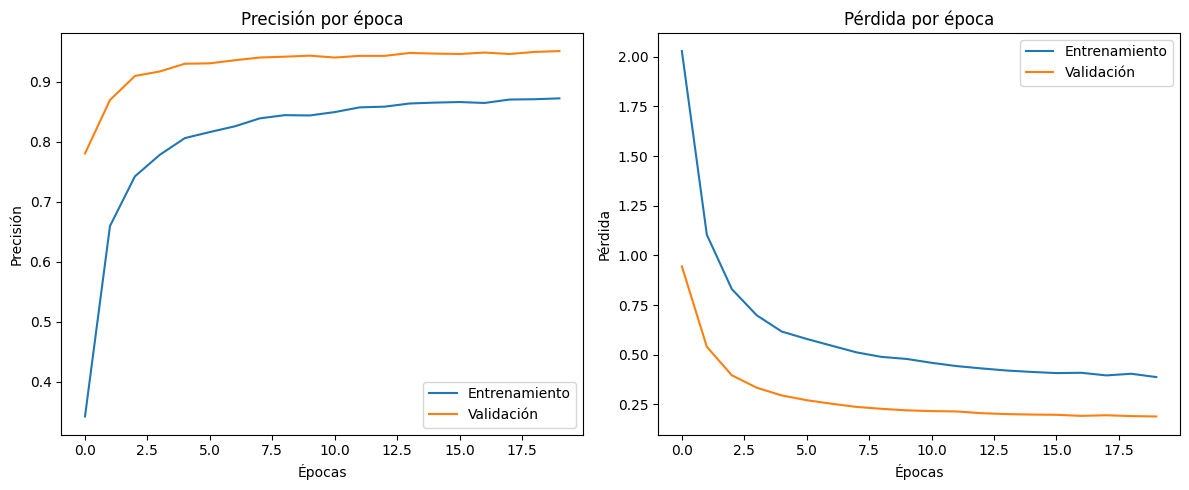

In [90]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()


plt.tight_layout()
plt.show()




Realizando predicciones en el conjunto de validación...
1/1 [==============================] - 0s 14ms/step


2025-06-17 21:11:50.875062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


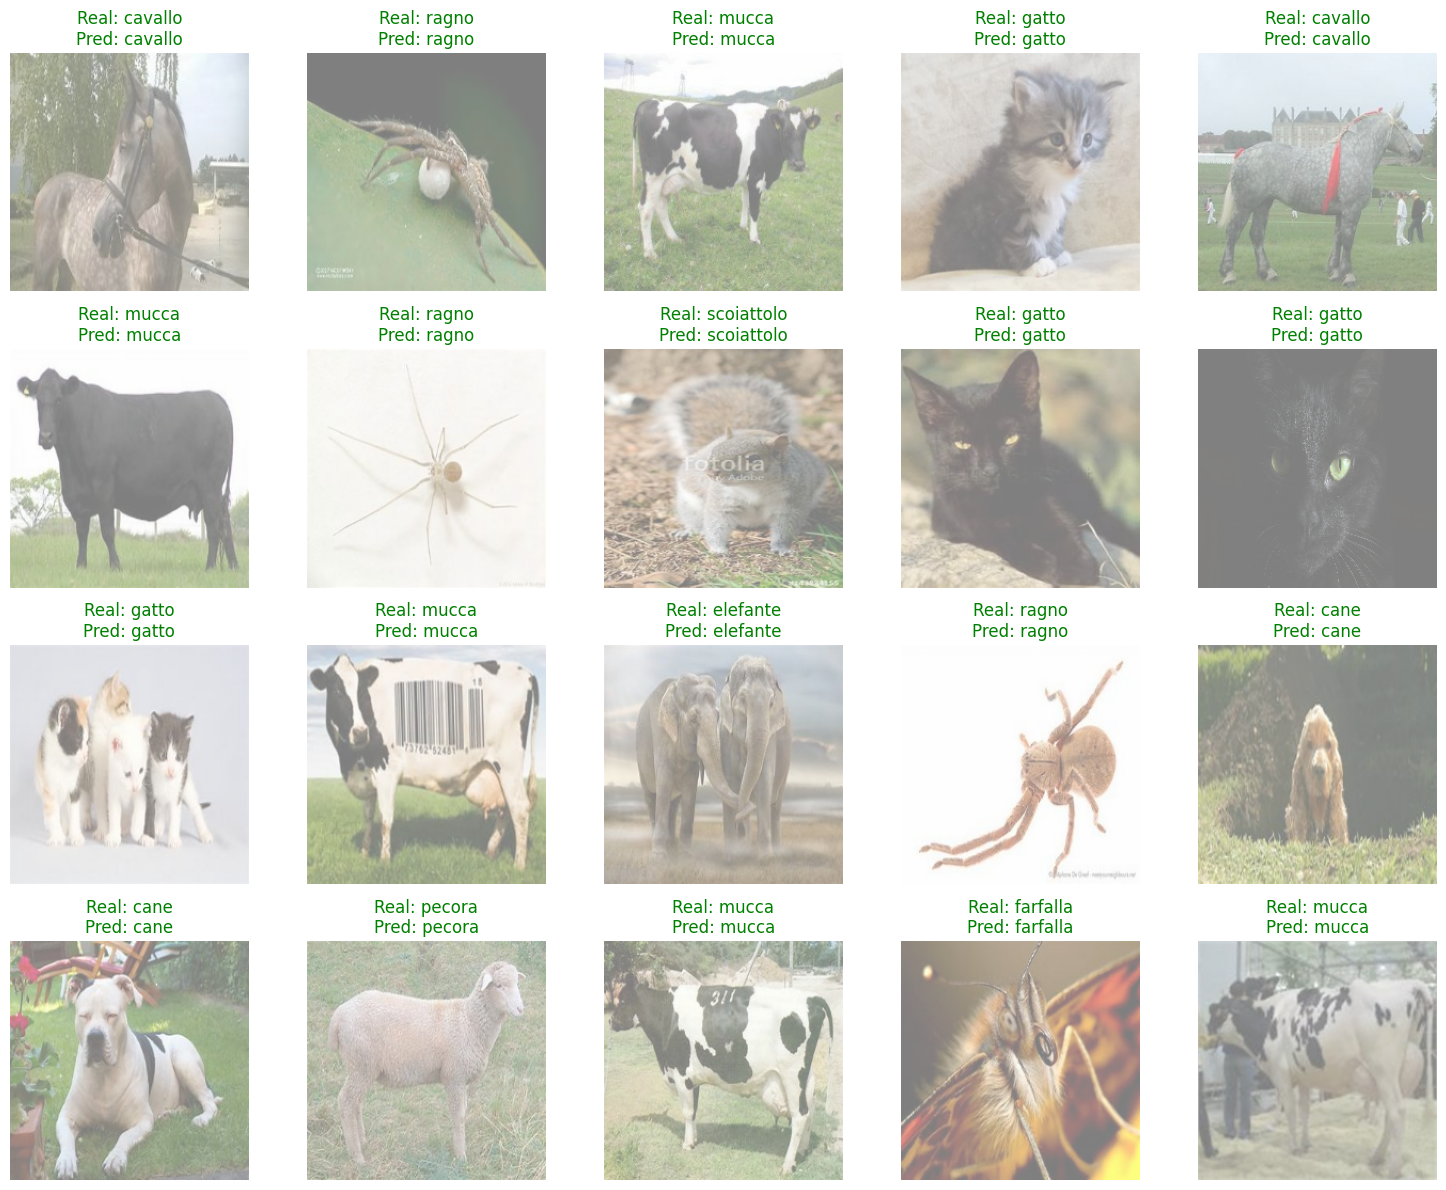

Visualización completa.


In [92]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf



print("\nRealizando predicciones en el conjunto de validación...")

for images, labels in val_ds.take(1):
    # Selecciona las primeras 20 del batch
    images_subset = images[:20]
    labels_subset = labels[:20]
    break 

# Hacer predicciones con el modelo
predictions = model.predict(images_subset)

# Obtener los índices de clase predichos (el que tiene mayor probabilidad)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener los nombres de clase reales y predichos
actual_class_names = [class_names[label.numpy()] for label in labels_subset]
predicted_class_names = [class_names[predicted_classes] for predicted_classes in predicted_classes]

# Invertir la normalización para mostrar las imágenes correctamente
# (De [-1, 1] de vuelta a [0, 255] y tipo uint8)
display_images = ((images_subset.numpy() + 1) * 127.5).astype(np.uint8)

# Mostrar las imágenes con sus etiquetas reales y predichas
plt.figure(figsize=(15, 12)) # Ajusta el tamaño de la figura si es necesario

for i in range(20):
    plt.subplot(4, 5, i + 1) # Layout de 4 filas y 5 columnas
    plt.imshow(display_images[i])

    # Define el color del título (verde si acierta, rojo si falla)
    color = 'green' if actual_class_names[i] == predicted_class_names[i] else 'red'

    # Pon el título con las etiquetas real y predicha
    plt.title(f"Real: {actual_class_names[i]}\nPred: {predicted_class_names[i]}", color=color)
    plt.axis('off') # Oculta los ejes

plt.tight_layout() # Ajusta el layout para que no se superpongan los títulos
plt.show()

print("Visualización completa.")

2025-06-17 21:15:45.650213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-17 21:15:45.769765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/91 [>.............................] - ETA: 2s

2025-06-17 21:15:46.315110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/91 [===============>..............] - ETA: 1s

2025-06-17 21:15:47.616272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


91/91 [==============================] - 3s 30ms/step
Classification Report:
              precision    recall  f1-score   support

        cane       0.92      0.94      0.93       286
     cavallo       0.95      0.93      0.94       284
    elefante       0.95      0.98      0.96       277
    farfalla       0.98      0.98      0.98       300
     gallina       0.99      0.96      0.97       286
       gatto       0.95      0.96      0.96       288
       mucca       0.92      0.90      0.91       312
      pecora       0.90      0.94      0.92       282
       ragno       0.99      0.98      0.98       287
  scoiattolo       0.99      0.95      0.97       290

    accuracy                           0.95      2892
   macro avg       0.95      0.95      0.95      2892
weighted avg       0.95      0.95      0.95      2892



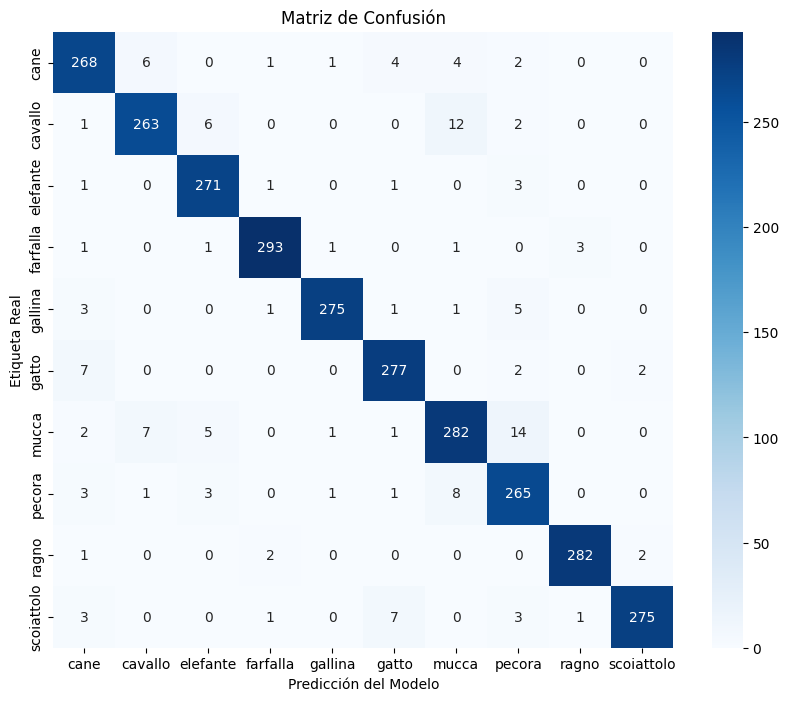

In [93]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las etiquetas verdaderas y las predicciones
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generar el Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generar la Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()



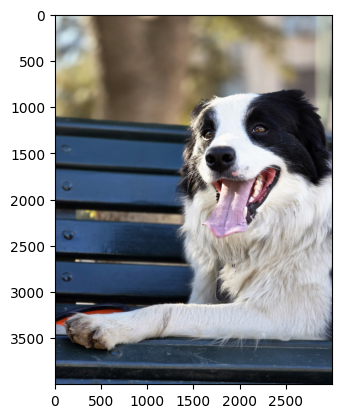

In [ ]:
haru = Image.open('haru.jpeg')

plt.imshow(haru)
plt.show()

In [102]:
target_size = (224, 224)
resized_image = haru.resize(target_size)  # Si usas PIL
# O con OpenCV: resized_image = cv2.resize(image, target_size)

# Convertir a array NumPy
image_array = np.array(resized_image)

image_array = image_array / 255.0

tensor = tf.expand_dims(image_array, axis=0)

# Verificar la forma del tensor (debe coincidir con la entrada del modelo)
print(tensor.shape)  #

(1, 224, 224, 3)


In [104]:
model.predict(tensor)

1/1 [==============================] - 1s 935ms/step


array([[8.9165014e-01, 1.6264835e-02, 6.9737271e-03, 9.1156457e-03,
        1.1131297e-02, 5.9155035e-03, 6.6772974e-03, 4.6346039e-02,
        5.6346953e-03, 2.9077864e-04]], dtype=float32)

In [106]:
predicted_class = np.argmax(predictions, axis=1)[0]

print("Probabilidades:", predictions)
print("Clase predicha:", predicted_class)

Probabilidades: [[1.73900684e-04 7.42573082e-01 2.42054537e-01 2.55830105e-06
  6.80128651e-05 5.82519933e-05 1.42425885e-02 7.21164164e-04
  2.10904709e-05 8.48776326e-05]
 [7.84482472e-05 8.59110005e-05 2.97796447e-04 3.08958406e-04
  6.88466525e-06 3.31077790e-05 4.32380839e-05 1.26992934e-04
  9.98986900e-01 3.18550192e-05]
 [3.50787632e-05 1.15408283e-03 1.69776595e-05 5.69477606e-06
  5.39940811e-06 1.52405698e-06 9.98604596e-01 1.75521476e-04
  1.11135489e-06 3.89537647e-08]
 [1.51860784e-03 5.41947156e-05 5.01651011e-05 6.01053616e-05
  4.93630687e-05 9.98011053e-01 1.52315624e-05 1.20578588e-05
  3.36416670e-05 1.95642147e-04]
 [7.73922715e-04 7.39639223e-01 1.09073892e-03 1.26893356e-05
  9.62473277e-04 3.95569921e-04 1.50904328e-01 1.06204085e-01
  1.14371478e-05 5.45061403e-06]
 [2.72013658e-05 2.16981047e-03 3.94191069e-04 6.00340063e-05
  1.21925787e-05 2.04179651e-05 9.86262023e-01 1.10473214e-02
  4.86438057e-06 1.97695590e-06]
 [1.01667084e-03 4.15026618e-04 4.33855457

In [107]:
class_names

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']